In [1]:
% matplotlib inline
# % config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
 
#SET UP FIGURE AESTHETICS 
plt.rcParams.update({'axes.labelsize': 20, 'font.size': 20,
                     'legend.fontsize': 18, 'xtick.labelsize': 18,
                     'ytick.labelsize': 18, 'axes.linewidth': 1.5})
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]

#Options
params = {'text.usetex' : True,
          'font.size' : 20,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

import pickle
from scipy.interpolate import interp1d

### used for pooling intensity map
import skimage.measure

from limlam_mocker import limlam_mocker as llm
#Get Parameters for run
from limlam_mocker import params        as params

import lnn as lnn

### load in models
from models_to_load import *

np.random.seed(1337)

%load_ext autoreload

In [2]:
%autoreload
# %autoreload 0
#%autoreload 2

# Setup Enviornment

In [3]:
import tensorflow as tf
from tensorflow import keras

mapLoc = '../maps2/basic_Li/'
different_mapLoc = '../maps2/random_maps2/'
random_small_Li_mapLoc = '../maps2/random_small_Li/'
basic_Padmanabhan_mapLoc = '../maps2/basic_Padmanabhan/'
catLoc = '../catalogues2/'
modelLoc = '../models2/'
modelLoc2 = '../models3/'
modelLoc4 = '../models4/'
modelLoc5 = '../models5/'
dataLoc = '../data/'
valPredictionLoc = dataLoc + 'predictions/'

### map info
numb_maps = 100
pix_x = 256
pix_y = 256

### output info
lum_func_size = 49
less_lums = 35

# Load Maps

In [4]:
subFields = lnn.loadBaseFNames(mapLoc)
base = [mapLoc + s for s in subFields]
lumLogBinCents = lnn.loadData(base[152] + '_lum.npz')['logBinCent']

subFields = lnn.loadBaseFNames(different_mapLoc)
different_base = [different_mapLoc + s for s in subFields]

# subFields = lnn.loadBaseFNames(random_small_Li_mapLoc)
# random_small_Li_base = [random_small_Li_mapLoc + s for s in subFields]

subFields = lnn.loadBaseFNames(random_small_Li_mapLoc)
np.random.seed(1234)
np.random.shuffle(subFields)
np.random.seed()

### shuffle  test and validation data
random_small_Li_base = [random_small_Li_mapLoc + s for s in subFields]


subFields = lnn.loadBaseFNames(basic_Padmanabhan_mapLoc)
np.random.seed(1234)
np.random.shuffle(subFields)
np.random.seed()

### shuffle  test and validation data
basic_Padmanabhan_base = [basic_Padmanabhan_mapLoc + s for s in subFields]

# Load Power Spectrum Results

In [5]:
def load_power_data(file_name):
    data = np.loadtxt(file_name, delimiter=',')
    lum = sorted(data[:,0])
    phi = list(sorted(data[:,1], reverse=True))
    return(lum, phi)

def interpolate_power_data(lum, phi, min_val, max_val):
    f = interp1d(lum, phi)
    
    new_lum = np.logspace(min_val,max_val,50)
    new_phi = f(new_lum)
    
    return(new_lum, new_phi)

In [6]:
# Load Harvard's data (this was screen scraped)
file_upper = 'comap_power_data/upper_limit.txt'
file_lower = 'comap_power_data/lower_limit.txt'
file_simulated = 'comap_power_data/underlying.txt'

# Data is storaed individually for the best fit line, lower 95% interval and upper 95% interval
upper_lum, upper_phi = lnn.load_power_data(file_upper)
lower_lum, lower_phi = lnn.load_power_data(file_lower)
simulated_lum, simulated_phi = lnn.load_power_data(file_simulated)

# get min and max log value to generate luminosities to get everything based on the same luminosities
min_val = np.log10(max([upper_lum[0], lower_lum[0], simulated_lum[0]]))
max_val = np.log10(min([upper_lum[-1], lower_lum[-1], simulated_lum[-1]]))

# interpolate the data to get everything on the same set of underlying luminosities
upper_lum, upper_phi = lnn.interpolate_power_data(upper_lum, upper_phi, min_val, max_val)
lower_lum, lower_phi = lnn.interpolate_power_data(lower_lum, lower_phi, min_val, max_val)
simulated_lum, simulated_phi = lnn.interpolate_power_data(simulated_lum, simulated_phi, min_val, max_val)

# Harvard's data is 
conversion_to_make_Harvards_data_match_mine = 10**6.3342749483296803
upper_phi = upper_phi * conversion_to_make_Harvards_data_match_mine
lower_phi = lower_phi * conversion_to_make_Harvards_data_match_mine
simulated_phi = simulated_phi * conversion_to_make_Harvards_data_match_mine

upper_err = (upper_phi - simulated_phi)/2
lower_err = (simulated_phi - lower_phi)/2

log_upper_err = upper_err / simulated_phi / np.log(10)
log_lower_err = lower_err / simulated_phi / np.log(10)
log_simulated_phi = np.log10(simulated_phi)

upper_ratio_log = log_upper_err/log_simulated_phi
lower_ratio_log = log_lower_err/log_simulated_phi
ratio = log_simulated_phi/log_simulated_phi

# Actual Plots

## Residual Plots

In [13]:
%autoreload

In [14]:
nfr_basic_resnet_basic_Li_p = lnn.load_pickle(valPredictionLoc + 'nfr_basic_resnet_corrected_basic_Li')
nfr_basic_resnet_basic_Li_pred = lnn.Prediction(nfr_basic_resnet_basic_Li_p, 'No Noise + Fiducial Li')

# nfr_noisy_resnet_basic_Li_p = lnn.load_pickle(valPredictionLoc + 'nfr_noisy_resnet_corrected_basic_Li')
# nfr_noisy_resnet_basic_Li_pred = lnn.Prediction(nfr_noisy_resnet_basic_Li_p, 'Fiducial Noise + Fiducial Li')

# nfr_noisy_foreground_random_resnet_basic_Li_p = lnn.load_pickle(valPredictionLoc + 'nfr_noisy_foreground_random_resnet_corrected_basic_Li')
# nfr_noisy_foreground_random_resnet_basic_Li_pred = lnn.Prediction(nfr_noisy_foreground_random_resnet_basic_Li_p, 'Random Noise/Foregrounds + Fiducial Li')


# nfr_basic_resnet_p = lnn.load_pickle(valPredictionLoc + 'nfr_basic_resnet_corrected')
# nfr_basic_resnet_pred = lnn.Prediction(nfr_basic_resnet_p, 'No Noise + Random Li')

# nfr_noisy_resnet_p = lnn.load_pickle(valPredictionLoc + 'nfr_noisy_resnet_corrected')
# nfr_noisy_resnet_pred = lnn.Prediction(nfr_noisy_resnet_p, 'Fiducial Noise + Random Li')

# nfr_noisy_foreground_random_resnet_p = lnn.load_pickle(valPredictionLoc + 'nfr_noisy_foreground_random_resnet_corrected')
# nfr_noisy_foreground_random_resnet_pred = lnn.Prediction(nfr_noisy_foreground_random_resnet_p, 'Random Noise/Foregrounds + Random Li')


# basic_Padmanabhan_p = lnn.load_pickle(valPredictionLoc + 'basic_Padmanabhan_corrected')
# basic_Padmanabhan_pred = lnn.Prediction(basic_Padmanabhan_p, 'Padmanabhan')

# geometric_noise_p = lnn.load_pickle(valPredictionLoc + 'geometric_noise_corrected')
# geometric_noise_pred = lnn.Prediction(geometric_noise_p, 'Geometric Noise')

# less_high_sources_p = lnn.load_pickle(valPredictionLoc + 'less_high_sources_corrected')
# less_high_sources_pred = lnn.Prediction(less_high_sources_p, 'Less Bright Sources')

In [9]:
# res_list2 = [nfr_basic_resnet_basic_Li_pred, 
#              nfr_foreground_resnet_basic_Li_pred, nfr_noisy_foreground_resnet_basic_Li_pred]
res_list2 = [nfr_basic_resnet_basic_Li_pred, nfr_noisy_resnet_basic_Li_pred, 
             nfr_noisy_foreground_random_resnet_basic_Li_pred]
res_list2.reverse()

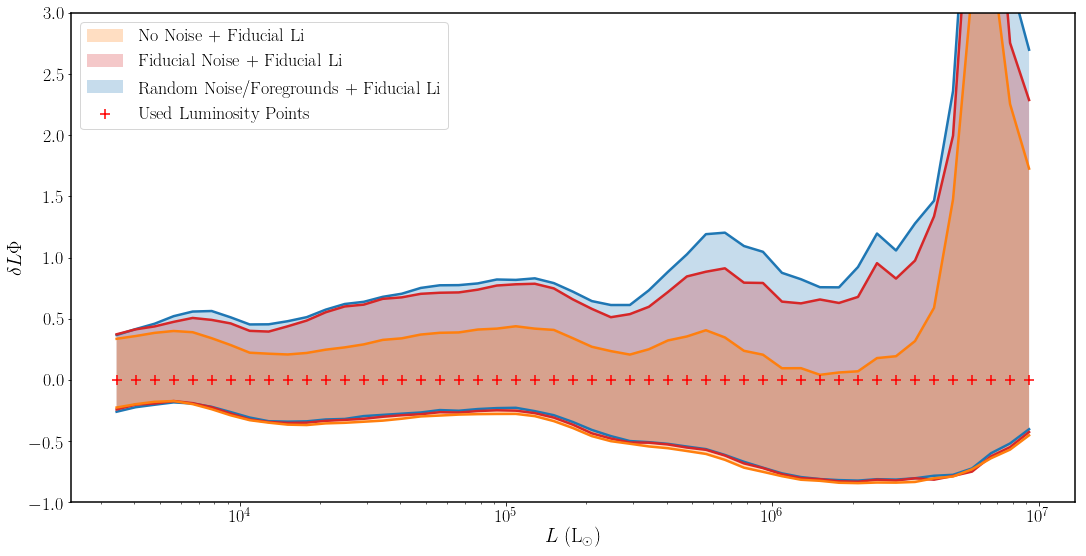

In [10]:
colors = ['tab:blue', 'tab:red', 'tab:orange']

ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, 
                           alpha=0.25, colors=colors, plot_range=[-1, 3])#plot_range=[-1, 9])

handles, labels = ax.get_legend_handles_labels()
ordering = [2,1,0,3]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
plt.show(ax)
# plt.savefig('../figures/basic_Li_comparison.pdf', bbox_inches='tight')

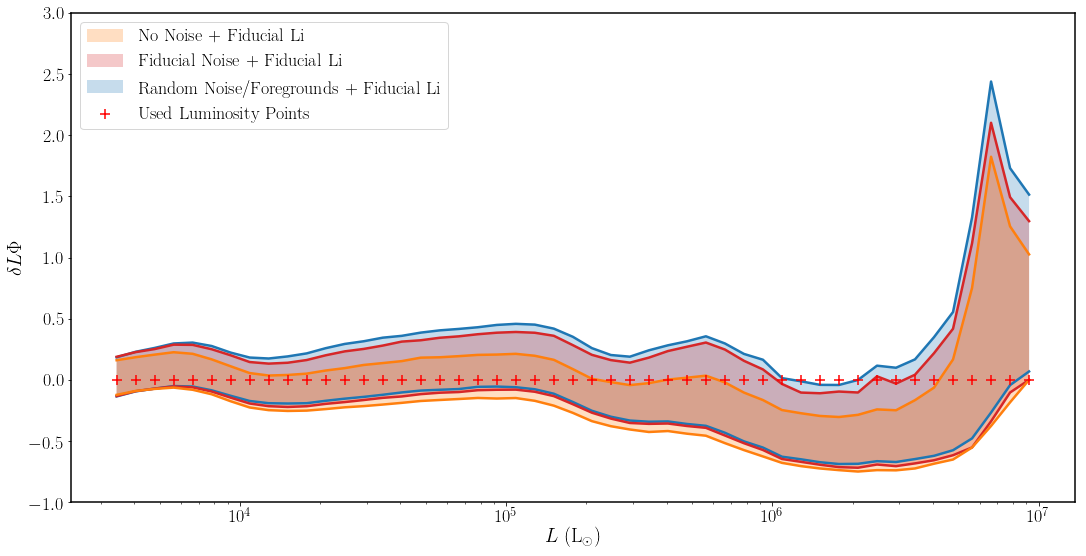

In [85]:
colors = ['tab:blue', 'tab:red', 'tab:orange']

ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, 
                           alpha=0.25, colors=colors, plot_range=[-1, 3], conf=1)#plot_range=[-1, 9])

handles, labels = ax.get_legend_handles_labels()
ordering = [2,1,0,3]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
# plt.show(ax)
plt.savefig('../figures/basic_Li_comparison_small.pdf', bbox_inches='tight')

In [86]:
# res_list2 = [nfr_basic_resnet_pred, 
#              nfr_foreground_resnet_pred, nfr_noisy_foreground_resnet_pred]
res_list2 = [nfr_basic_resnet_pred, nfr_noisy_resnet_pred, 
             nfr_noisy_foreground_random_resnet_pred]
res_list2.reverse()

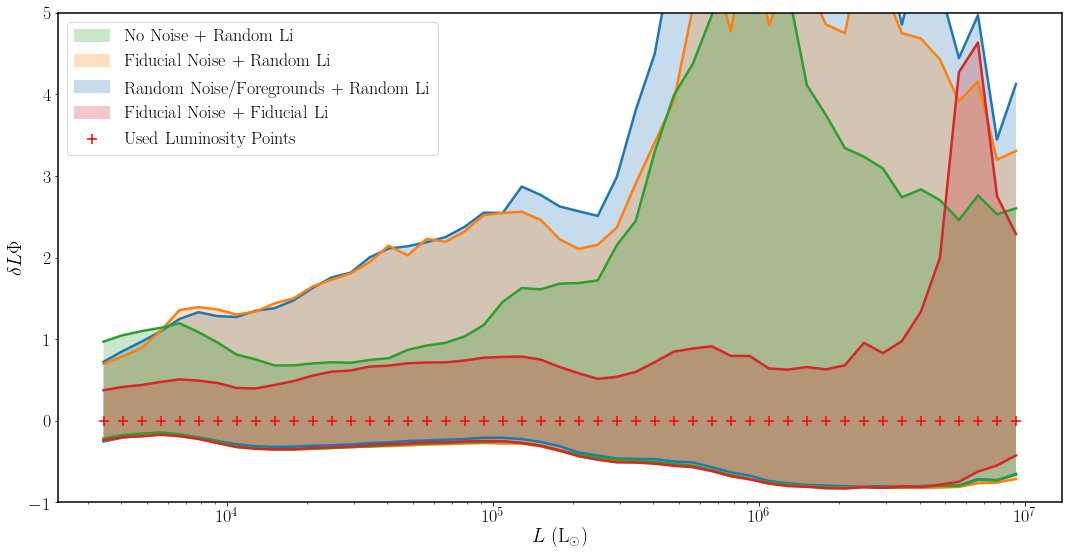

In [87]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, plot_range=[-1, 5])#plot_range=[-1, 25])

color = 'tab:red'
lnn.plot_res_contour(ax, nfr_noisy_resnet_basic_Li_pred, lumLogBinCents, alpha=0.25, color=color,
                label='Fiducial Noise + Fiducial Li')

handles, labels = ax.get_legend_handles_labels()
ordering = [2,1,0,4,3]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
# plt.show(ax)
plt.savefig('../figures/small_Li_comparison.pdf', bbox_inches='tight')

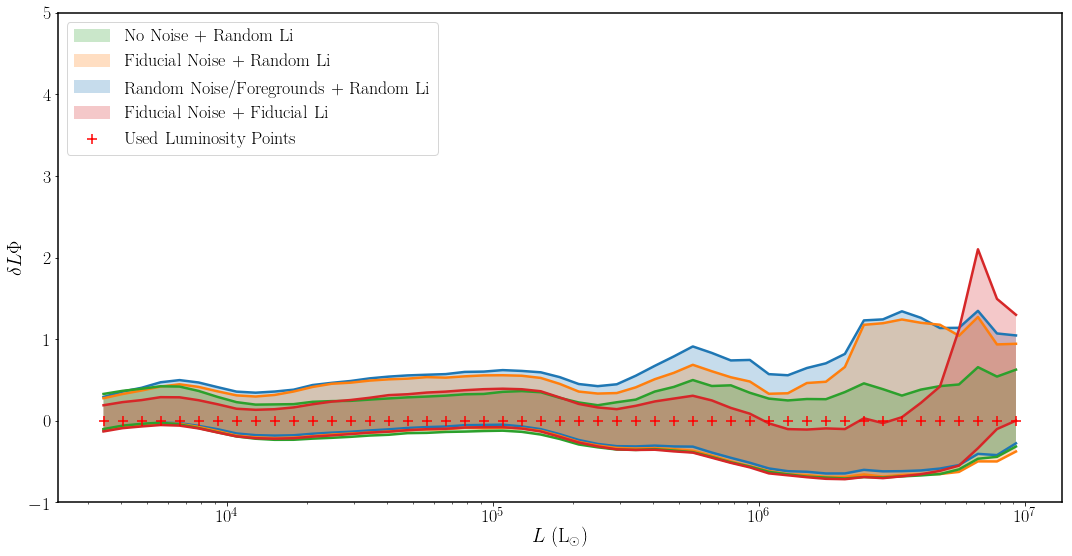

In [88]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, plot_range=[-1, 5], conf=1)#plot_range=[-1, 25])

color = 'tab:red'
lnn.plot_res_contour(ax, nfr_noisy_resnet_basic_Li_pred, lumLogBinCents, alpha=0.25, color=color,
                label='Fiducial Noise + Fiducial Li', conf=1)

handles, labels = ax.get_legend_handles_labels()
ordering = [2,1,0,4,3]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
# plt.show(ax)
plt.savefig('../figures/small_Li_comparison_small.pdf', bbox_inches='tight')

In [12]:
res_list2 = [basic_Padmanabhan_pred, 
             less_high_sources_pred, geometric_noise_pred]
res_list2.reverse()

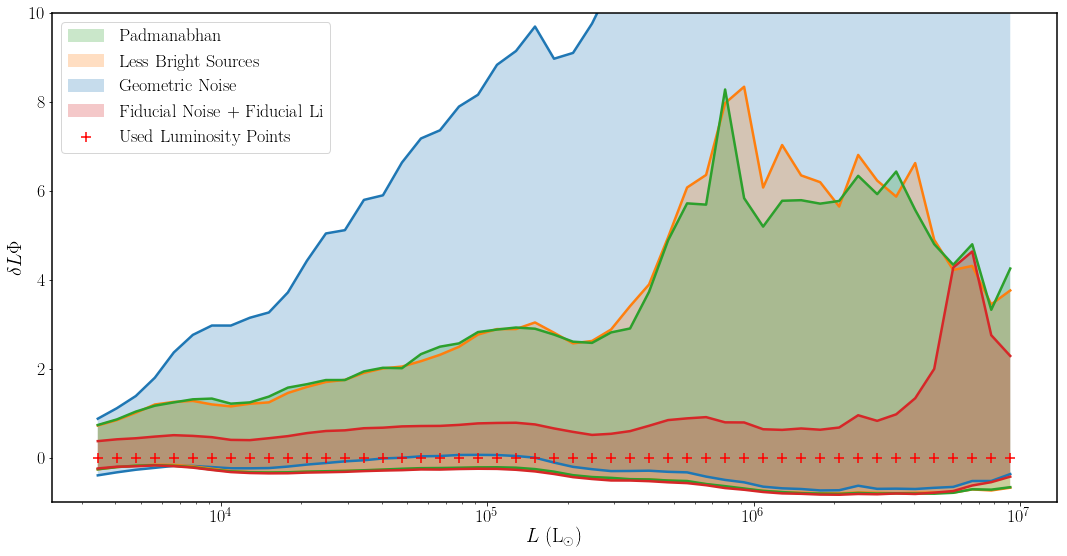

In [13]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, plot_range=[-1, 10])#plot_range=[-1, 25])

color = 'tab:red'
lnn.plot_res_contour(ax, nfr_noisy_resnet_basic_Li_pred, lumLogBinCents, alpha=0.25, color=color,
                 label='Fiducial Noise + Fiducial Li')

handles, labels = ax.get_legend_handles_labels()
ordering = [2,1,0,4,3]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
plt.show(ax)
# plt.savefig('../figures/random_comparison.pdf', bbox_inches='tight')

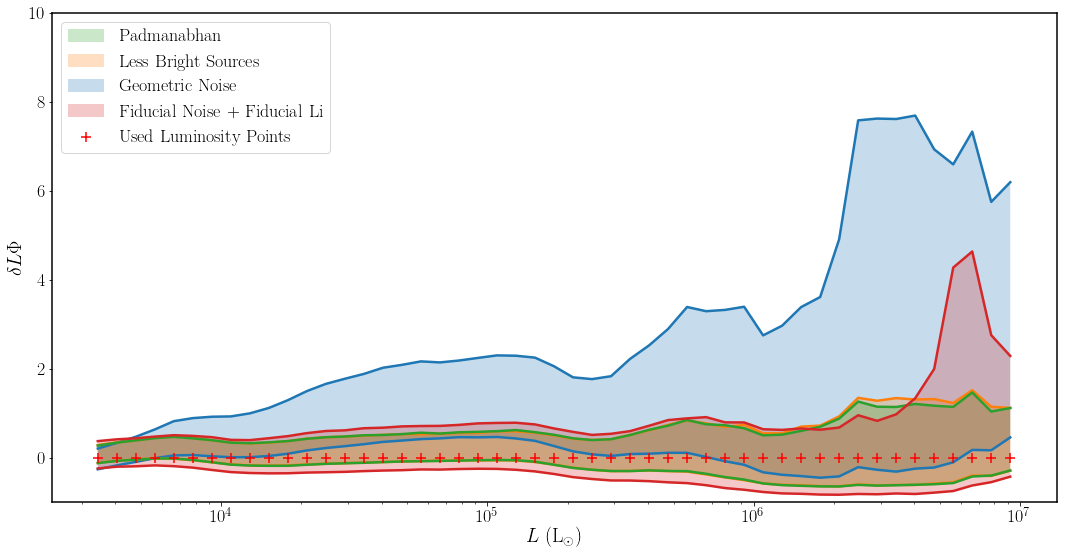

In [91]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, plot_range=[-1, 10], conf=1)#plot_range=[-1, 25])

color = 'tab:red'
lnn.plot_res_contour(ax, nfr_noisy_resnet_basic_Li_pred, lumLogBinCents, alpha=0.25, color=color,
                 label='Fiducial Noise + Fiducial Li')

handles, labels = ax.get_legend_handles_labels()
ordering = [2,1,0,4,3]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
# plt.show(ax)
plt.savefig('../figures/random_comparison_small.pdf', bbox_inches='tight')

In [92]:
res_list2 = [nfr_noisy_resnet_basic_Li_pred]
res_list2.reverse()

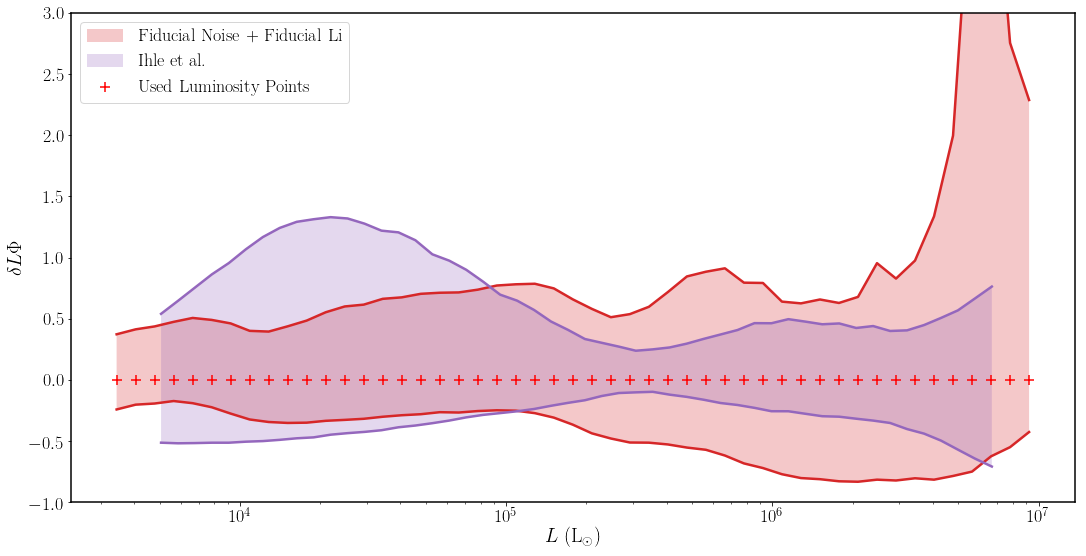

In [93]:
colors = ['tab:red']
ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, plot_range=[-1, 3])#plot_range=[-1, 10])

color = 'tab:purple'
ax = lnn.plot_outside_contour(ax, [-2*lower_err/simulated_phi, 2*upper_err/simulated_phi], simulated_lum, 
                          'Ihle et al.', alpha=0.25, color=color)

handles, labels = ax.get_legend_handles_labels()
ordering = [0,2,1]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
# plt.show(ax)
plt.savefig('../figures/Ihle_comparison.pdf', bbox_inches='tight')

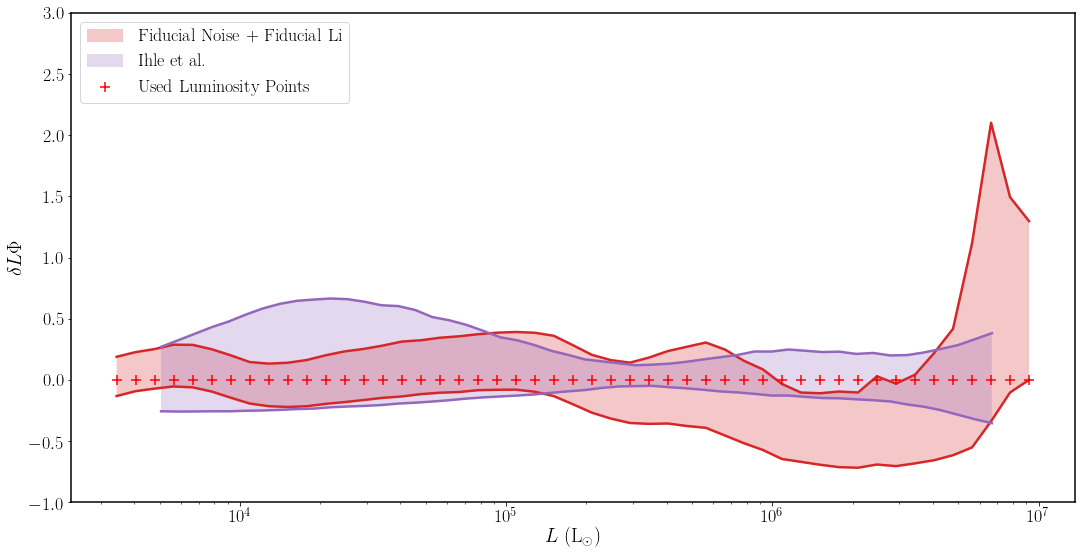

In [94]:
colors = ['tab:red']
ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, plot_range=[-1, 3], conf=1)#plot_range=[-1, 10])

color = 'tab:purple'
ax = lnn.plot_outside_contour(ax, [-1*lower_err/simulated_phi, 1*upper_err/simulated_phi], simulated_lum, 
                          'Ihle et al.', alpha=0.25, color=color)

handles, labels = ax.get_legend_handles_labels()
ordering = [0,2,1]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
# plt.show(ax)
plt.savefig('../figures/Ihle_comparison_small.pdf', bbox_inches='tight')

In [95]:
lums = lnn.loadLums(base[-836]+'_lum.npz', 'basic') #-836

f = interp1d(lumLogBinCents, lums)
lum_to_ihle = f(simulated_lum)

conversion_to_make_Harvards_data_match_mine = 10**6.3342749483296803
conv = conversion_to_make_Harvards_data_match_mine

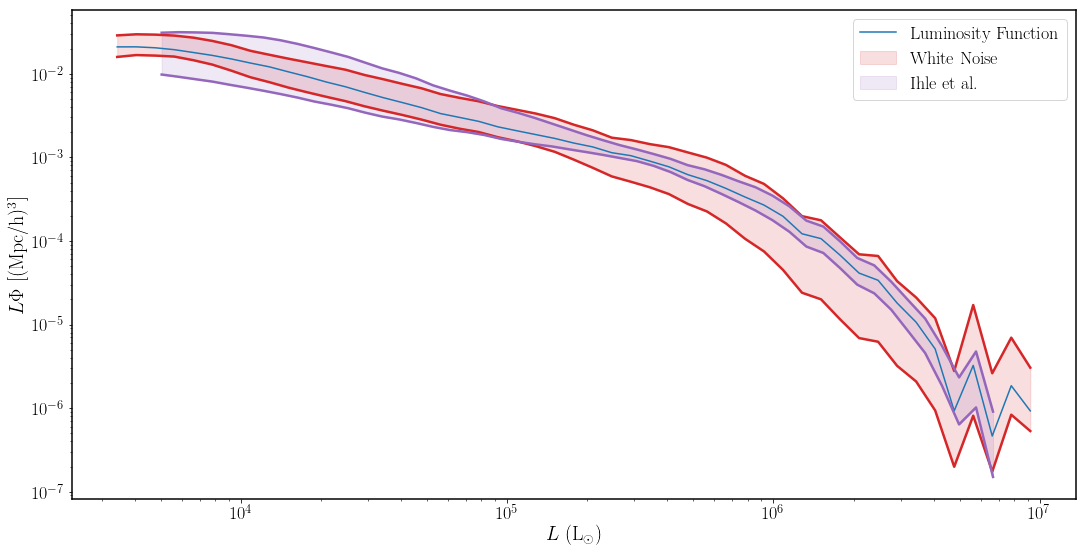

In [96]:
fig, ax = plt.subplots(figsize=(18, 9))

ax.plot(lumLogBinCents, lums/conv, label='Luminosity Function')

color = 'tab:red'
p = ax.fill_between(lumLogBinCents, lums*(1+nfr_noisy_resnet_basic_Li_pred.transformed_res_conf_interval[:,0])/conv, 
                 lums*(1+nfr_noisy_resnet_basic_Li_pred.transformed_res_conf_interval[:,1])/conv, 
                 alpha=0.15, label='White Noise', color=color)
color = p.get_facecolor()
ax.plot(lumLogBinCents[:nfr_noisy_resnet_basic_Li_pred.lum_func_size], 
        lums*(1+nfr_noisy_resnet_basic_Li_pred.transformed_res_conf_interval[:,0])/conv, 
        color=color[0][:-1], linewidth=2.5)
ax.plot(lumLogBinCents[:nfr_noisy_resnet_basic_Li_pred.lum_func_size], 
        lums*(1+nfr_noisy_resnet_basic_Li_pred.transformed_res_conf_interval[:,1])/conv, 
        color=color[0][:-1], linewidth=2.5)

color = 'tab:purple'
p = ax.fill_between(simulated_lum, lum_to_ihle*(1-2*lower_err/simulated_phi)/conv, 
                    lum_to_ihle*(1+2*upper_err/simulated_phi)/conv, 
                 alpha=0.15, label='Ihle et al.', color=color)
color = p.get_facecolor()
ax.plot(simulated_lum, lum_to_ihle*(1-2*lower_err/simulated_phi)/conv, color=color[0][:-1], linewidth=2.5)
ax.plot(simulated_lum, lum_to_ihle*(1+2*upper_err/simulated_phi)/conv, color=color[0][:-1], linewidth=2.5)

plt.xscale('log')
plt.yscale('log')
# plt.ylim([-0.75,0.75])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^3$]')
plt.legend()

# plt.show(ax)
plt.savefig('../figures/Ihle_comparison_raw.pdf', bbox_inches='tight')

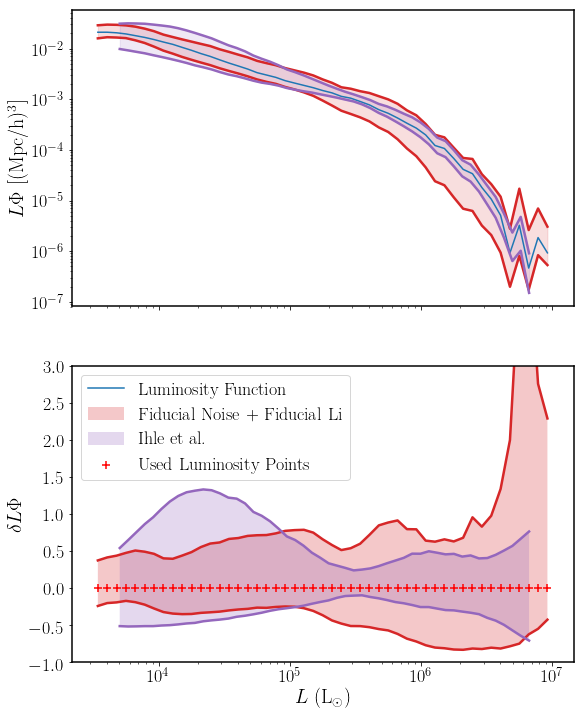

In [97]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 12))

ax[0].plot(lumLogBinCents, lums/conv, label='Luminosity Function')

color = 'tab:red'
p = ax[0].fill_between(lumLogBinCents, lums*(1+nfr_noisy_resnet_basic_Li_pred.transformed_res_conf_interval[:,0])/conv, 
                 lums*(1+nfr_noisy_resnet_basic_Li_pred.transformed_res_conf_interval[:,1])/conv, 
                 alpha=0.15, label='White Noise', color=color)
color = p.get_facecolor()
ax[0].plot(lumLogBinCents[:nfr_noisy_resnet_basic_Li_pred.lum_func_size], 
        lums*(1+nfr_noisy_resnet_basic_Li_pred.transformed_res_conf_interval[:,0])/conv, 
        color=color[0][:-1], linewidth=2.5)
ax[0].plot(lumLogBinCents[:nfr_noisy_resnet_basic_Li_pred.lum_func_size], 
        lums*(1+nfr_noisy_resnet_basic_Li_pred.transformed_res_conf_interval[:,1])/conv, 
        color=color[0][:-1], linewidth=2.5)

color = 'tab:purple'
p = ax[0].fill_between(simulated_lum, lum_to_ihle*(1-2*lower_err/simulated_phi)/conv, 
                       lum_to_ihle*(1+2*upper_err/simulated_phi)/conv, 
                 alpha=0.15, label='Ihle et al.', color=color)
color = p.get_facecolor()
ax[0].plot(simulated_lum, lum_to_ihle*(1-2*lower_err/simulated_phi)/conv, color=color[0][:-1], linewidth=2.5)
ax[0].plot(simulated_lum, lum_to_ihle*(1+2*upper_err/simulated_phi)/conv, color=color[0][:-1], linewidth=2.5)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('$L \Phi$ [(Mpc/h)$^3$]')


colors = ['tab:red']
ax[1] = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, plot_range=[-1, 3], 
                                  ax=ax[1], lum_point_size=50)

color = 'tab:purple'
ax[1] = lnn.plot_outside_contour(ax[1], [-2*lower_err/simulated_phi, 2*upper_err/simulated_phi], simulated_lum, 
                          'Ihle et al.', alpha=0.25, color=color)

handles_top, labels_top= ax[0].get_legend_handles_labels()

handles_bottom, labels_bottom = ax[1].get_legend_handles_labels()
ordering_bottom = [0,2,1]
handles_bottom = [handles_top[0]] + [handles_bottom[i] for i in ordering_bottom]
labels_bottom = [labels_top[0]] + [labels_bottom[i] for i in ordering_bottom]
ax[1].legend(handles_bottom, labels_bottom, loc='upper left')

ax[1].set_ylabel(r'$\delta L \Phi$')
ax[1].set_xlabel(r'$L$ (L$_{\odot}$)')

# plt.show()
plt.savefig('../figures/Ihle_comparison_full.pdf', bbox_inches='tight')

In [98]:
res_list2 = [basic_Padmanabhan_pred, less_high_sources_pred, nfr_noisy_foreground_random_resnet_pred]
res_list2.reverse()

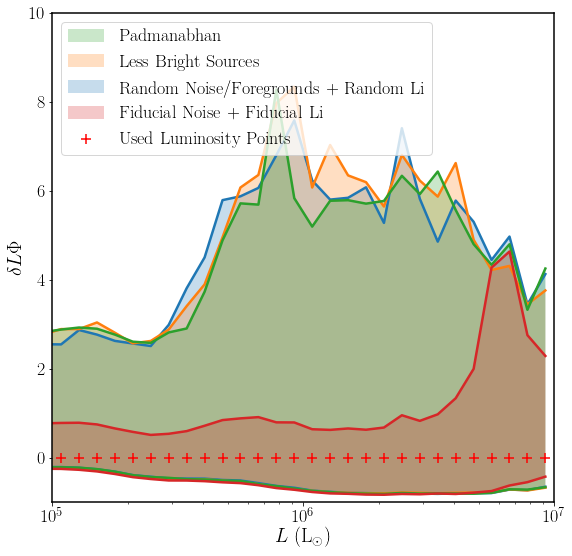

In [99]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, 
                           figsize=(9,9), plot_range=[-1, 10])#plot_range=[-1, 25])

color = 'tab:red'
lnn.plot_res_contour(ax, nfr_noisy_resnet_basic_Li_pred, lumLogBinCents, alpha=0.25, color=color,
                 label='Fiducial Noise + Fiducial Li')

handles, labels = ax.get_legend_handles_labels()
ordering = [2,1,0,4,3]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

ax.set_xlim([10**5, 10**7])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
# plt.show(ax)
plt.savefig('../figures/large_comparison.pdf', bbox_inches='tight')

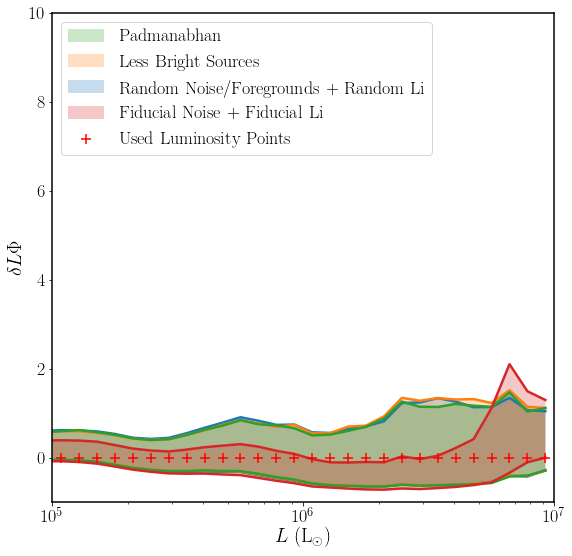

In [100]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, 
                           figsize=(9,9), plot_range=[-1, 10], conf=1)#plot_range=[-1, 25])

color = 'tab:red'
lnn.plot_res_contour(ax, nfr_noisy_resnet_basic_Li_pred, lumLogBinCents, alpha=0.25, color=color,
                 label='Fiducial Noise + Fiducial Li', conf=1)

handles, labels = ax.get_legend_handles_labels()
ordering = [2,1,0,4,3]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

ax.set_xlim([10**5, 10**7])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
# plt.show(ax)
plt.savefig('../figures/large_comparison_small.pdf', bbox_inches='tight')

# History

In [49]:
%autoreload

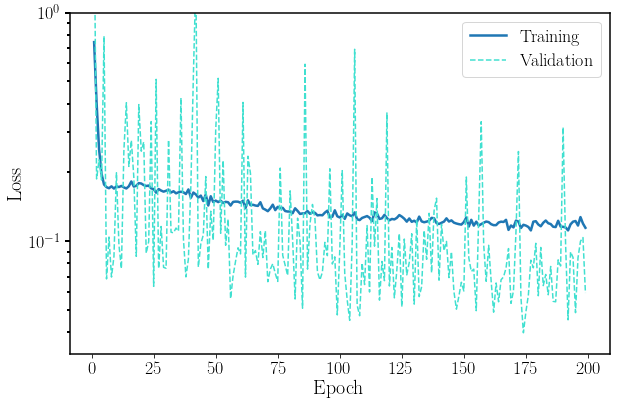

In [51]:
noisy_foreground_random_resnet_history = lnn.get_full_history('noisy_foreground_random_resnet_corrected', modelLoc5)
ax = lnn.plot_single_history(noisy_foreground_random_resnet_history, second_color='turquoise')

ax.yaxis.set_tick_params(width=2, size=5)

for line in ax.yaxis.get_minorticklines():
    line.set_markersize(3)
    line.set_markeredgewidth(2)

lims = ax.get_ylim()
ax.set_ylim(lims[0], 1)
# ax.set_xlim(0, 200)

# plt.show(ax)
plt.savefig('../figures/training_history.pdf', bbox_inches='tight')

## Training Data

In [10]:
mapLoc_small = '../maps2/random_small_Li/'

subFields = lnn.loadBaseFNames(mapLoc_small)
small_base = [mapLoc_small + s for s in subFields]
lums = lnn.load_lums(small_base, lumLogBinCents)

means = np.zeros(len(lums[0]))
lower = np.zeros(len(lums[0]))
upper = np.zeros(len(lums[0]))

for i, val in enumerate(lums[0]):
    means[i] = np.mean(lums[:,i])
    ls = sorted(lums[:,i])[145:-145]
    
    lower[i] = (means[i] - ls[0]) / 2
    upper[i] = (ls[-1] - means[i]) / 2
    
conv = conversion_to_make_Harvards_data_match_mine

In [11]:
lums = lnn.load_lums(base, lumLogBinCents)

means_fid = np.zeros(len(lums[0]))

for i, val in enumerate(lums[0]):
    means_fid[i] = np.mean(lums[:,i])
    
conv = conversion_to_make_Harvards_data_match_mine

In [12]:
conversion_to_make_Harvards_data_match_mine = 10**6.3342749483296803
conv = conversion_to_make_Harvards_data_match_mine

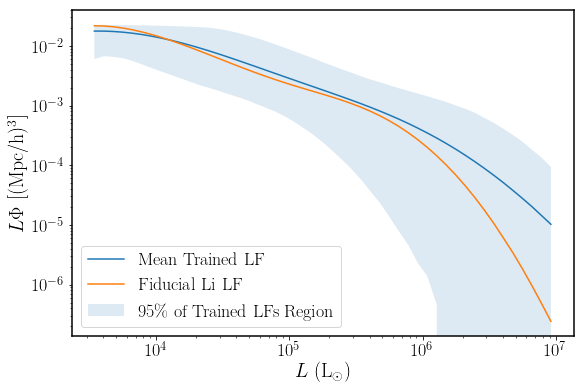

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))

plt.fill_between(lumLogBinCents, (means-2*lower)/conv, (means+2*upper)/conv, alpha=0.15, label='95\% of Trained LFs Region')
plt.plot(lumLogBinCents, means/conv, label='Mean Trained LF')
plt.plot(lumLogBinCents, means_fid/conv, label='Fiducial Li LF')
# plt.plot(lumLogBinCents, means_Pad/conv, label='Fiducial Padmanabhan LF')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([-0.75,0.75])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^3$]')
# plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend()

plt.show(ax)
# plt.savefig('../figures/training_lum_funcs.pdf', bbox_inches='tight')

In [72]:
mapLoc_small = '../maps2/basic_Padmanabhan/'

subFields = lnn.loadBaseFNames(mapLoc_small)
small_base = [mapLoc_small + s for s in subFields]
lums = lnn.load_lums(small_base, lumLogBinCents)

means_Pad = np.zeros(len(lums[0]))

for i, val in enumerate(lums[0]):
    means_Pad[i] = np.mean(lums[:,i])
    
conv = conversion_to_make_Harvards_data_match_mine

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

plt.fill_between(lumLogBinCents, (means-2*lower)/conv, (means+2*upper)/conv, alpha=0.15, label='95\% of Trained LFs Region')
# plt.plot(lumLogBinCents, means/conv, label='Mean Trained LF')
plt.plot(lumLogBinCents, means_fid/conv, label='Fiducial Li LF')
plt.plot(lumLogBinCents, means_Pad/conv, label='Fiducial Padmanabhan LF')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([-0.75,0.75])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^3$]')
# plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend()

# plt.show(ax)
plt.savefig('../figures/training_lum_funcs_pad.pdf', bbox_inches='tight')

## Network Test

In [7]:
%autoreload

In [8]:
noisy_foreground_random_resnet = get_master_res_next(modelLoc5, 64, 64, 10, lum_func_size,
                extra_file_name='', file_name='noisy_foreground_random_resnet_corrected2',
                dense_layer=1000, base_filters=64, cardinality=1,
                give_weights=True, use_bias=True)

In [41]:
noisy_foreground_random_resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 10, 1 0                                            
__________________________________________________________________________________________________
conv3d_159 (Conv3D)             (None, 32, 32, 5, 64 22016       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, 32, 32, 5, 64 256         conv3d_159[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_147 (LeakyReLU)     (None, 32, 32, 5, 64 0           batch_normalization_162[0][0]    
__________________________________________________________________________________________________
max_poolin

In [10]:
conversion_to_make_Harvards_data_match_mine = 10**6.3342749483296803
conv = conversion_to_make_Harvards_data_match_mine

In [9]:
%autoreload

In [48]:
# Uses the last 20% of data as validation so it wants the value from the back of the array

# numb = np.random.choice(range(len(random_small_Li_base[-1000:])), 1)[0]
numb = 1

print(numb, random_small_Li_base[-numb], '----------------------------')

cur_lum_good, cnn_lum_good, loss = lnn.test_model(noisy_foreground_random_resnet, random_small_Li_base, -numb, 'log', True, pre_pool=4, 
                                      log_input=True, pre_pool_z=10, lum_func_size=lum_func_size,
                                       make_map_noisy=(0,6.31), add_foregrounds=True,
                                       random_foreground_params=True, gaussian_smoothing=3,
                                                 pix_x=256, pix_y=256)

1 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13737_rotate_0_subfield_19__Li_-8.101e-02_1.394e+00_-1.909e+00_3.060e-01_2.917e-01 ----------------------------
Error and MSE for the given base_number:
[0.028174914419651031, 0.058437813073396683]


In [49]:
# Uses the last 20% of data as validation so it wants the value from the back of the array

# numb = np.random.choice(range(len(random_small_Li_base[-1159:])), 1)[0]
numb = 25 #19

print(numb, random_small_Li_base[-numb], '----------------------------')

cur_lum_eh, cnn_lum_eh, loss = lnn.test_model(noisy_foreground_random_resnet, random_small_Li_base, -numb, 'log', True, pre_pool=4, 
                                      log_input=True, pre_pool_z=10, lum_func_size=lum_func_size,
                                       make_map_noisy=(0,1), add_foregrounds=True,
                                       random_foreground_params=True, gaussian_smoothing=3)

25 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13873_rotate_0_subfield_23__Li_-4.163e-02_1.368e+00_-2.238e+00_3.027e-01_3.001e-01 ----------------------------
Error and MSE for the given base_number:
[0.015651185065507889, 0.031794305890798569]


In [50]:
# Uses the last 20% of data as validation so it wants the value from the back of the array

# numb = np.random.choice(range(len(random_small_Li_base[-1159:])), 1)[0]
numb = 363

print(numb, random_small_Li_base[-numb], '----------------------------')

cur_lum_bad, cnn_lum_bad, loss = lnn.test_model(noisy_foreground_random_resnet, random_small_Li_base, -numb, 'log', True, pre_pool=4, 
                                      log_input=True, pre_pool_z=10, lum_func_size=lum_func_size,
                                       make_map_noisy=(0,6.31), add_foregrounds=True,
                                       random_foreground_params=True, gaussian_smoothing=3)

363 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13689_rotate_0_subfield_24__Li_-2.399e-02_1.455e+00_-1.124e+00_2.975e-01_2.810e-01 ----------------------------
Error and MSE for the given base_number:
[0.15337179601192474, 0.36720576882362366]


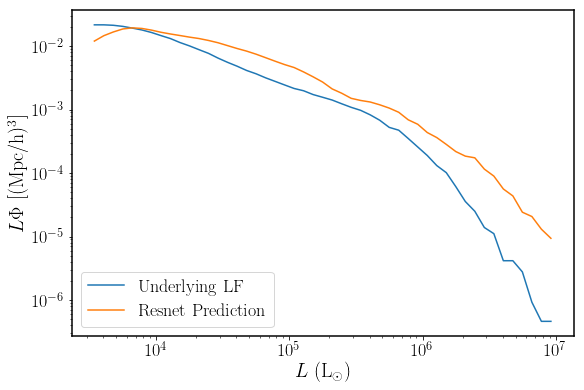

In [25]:
fig, ax = plt.subplots(figsize=(9, 6))

true_lum = 10**cur_lum_good
cnn_guess = 10**cnn_lum_good[0]

plt.plot(lumLogBinCents, true_lum/conv, label='Underlying LF')
plt.plot(lumLogBinCents, cnn_guess/conv, label='Resnet Prediction')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([1,10**5.5])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^3$]')
# # plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend(loc='lower left')

plt.show(ax)
# plt.savefig('../figures/guess_range_good.pdf', bbox_inches='tight')

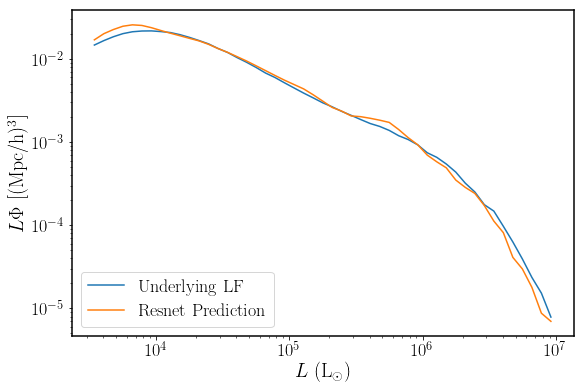

In [121]:
fig, ax = plt.subplots(figsize=(9, 6))

true_lum = 10**cur_lum_eh
cnn_guess = 10**cnn_lum_eh[0]

plt.plot(lumLogBinCents, true_lum/conv, label='Underlying LF')
plt.plot(lumLogBinCents, cnn_guess/conv, label='Resnet Prediction')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([1,10**5.5])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^3$]')
# # plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend(loc='lower left')

# plt.show(ax)
plt.savefig('../figures/guess_range_eh.pdf', bbox_inches='tight')

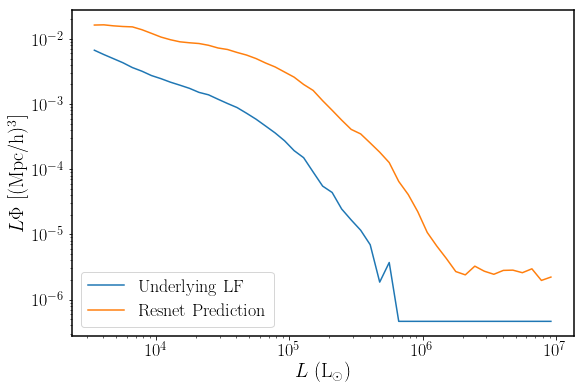

In [122]:
fig, ax = plt.subplots(figsize=(9, 6))

true_lum = 10**cur_lum_bad
cnn_guess = 10**cnn_lum_bad[0]

plt.plot(lumLogBinCents, true_lum/conv, label='Underlying LF')
plt.plot(lumLogBinCents, cnn_guess/conv, label='Resnet Prediction')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([1,10**5.5])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^3$]')
# # plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend(loc='lower left')

# plt.show(ax)
plt.savefig('../figures/guess_range_bad.pdf', bbox_inches='tight')

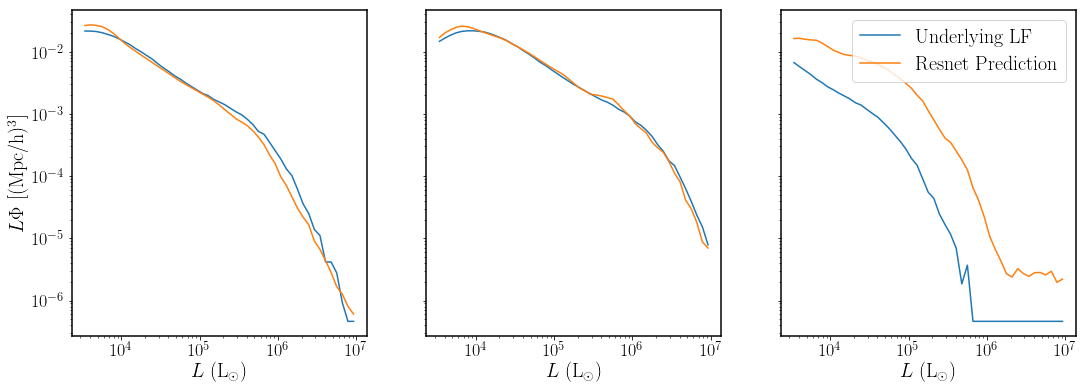

In [123]:
fig, ax = plt.subplots(1, 3, sharey='row', figsize=(18, 6))

true_lum_good = 10**cur_lum_good
cnn_guess_good = 10**cnn_lum_good[0]

true_lum_eh = 10**cur_lum_eh
cnn_guess_eh = 10**cnn_lum_eh[0]

true_lum_bad = 10**cur_lum_bad
cnn_guess_bad = 10**cnn_lum_bad[0]

ax[0].loglog(lumLogBinCents, true_lum_good/conv, label='Underlying LF')
ax[0].loglog(lumLogBinCents, cnn_guess_good/conv, label='Resnet Prediction')

ax[1].loglog(lumLogBinCents, true_lum_eh/conv, label='Underlying LF')
ax[1].loglog(lumLogBinCents, cnn_guess_eh/conv, label='Resnet Prediction')

ax[2].loglog(lumLogBinCents, true_lum_bad/conv, label='Underlying LF')
ax[2].loglog(lumLogBinCents, cnn_guess_bad/conv, label='Resnet Prediction')

ax[0].set_xlabel('$L$ (L$_{\odot}$)')
ax[0].set_ylabel('$L \Phi$ [(Mpc/h)$^3$]')

ax[1].set_xlabel('$L$ (L$_{\odot}$)')
# ax[1].legend(loc='upper right')

ax[2].set_xlabel('$L$ (L$_{\odot}$)')
ax[2].legend(loc='upper right', prop={'size': 20})

# plt.show()
plt.savefig('../figures/guess_range.pdf', bbox_inches='tight')

In [11]:
%autoreload

In [12]:
# Uses the last 20% of data as validation so it wants the value from the back of the array

# numb = np.random.choice(range(len(random_small_Li_base[-1000:])), 1)[0]
numb = 1

print(numb, random_small_Li_base[-numb], '----------------------------')

cur_lum_good, cnn_lum_good, loss = lnn.test_model(noisy_foreground_random_resnet, random_small_Li_base, -numb, 'log', True, pre_pool=4, 
                                      log_input=True, pre_pool_z=10, lum_func_size=lum_func_size,
                                       make_map_noisy=(0,6.31), add_foregrounds=True,
                                       random_foreground_params=True, gaussian_smoothing=3,
                                                 pix_x=256, pix_y=256)

1 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13737_rotate_0_subfield_19__Li_-8.101e-02_1.394e+00_-1.909e+00_3.060e-01_2.917e-01 ----------------------------
Error and MSE for the given base_number:
[0.0069647505879402161, 0.014042074792087078]


In [9]:
# Uses the last 20% of data as validation so it wants the value from the back of the array

# numb = np.random.choice(range(len(random_small_Li_base[-1000:])), 1)[0]
numb = 523

print(numb, random_small_Li_base[-numb], '----------------------------')

cur_lum_Pad, cnn_lum_Pad, loss = lnn.test_model(noisy_foreground_random_resnet, basic_Padmanabhan_base, -numb, 'log', True, pre_pool=4, 
                                      log_input=True, pre_pool_z=10, lum_func_size=lum_func_size,
                                       make_map_noisy=(0,6.31), add_foregrounds=True,
                                       random_foreground_params=True, gaussian_smoothing=3,
                                                 pix_x=256, pix_y=256)

523 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13695_rotate_0_subfield_22__Li_1.306e-02_1.381e+00_-1.770e+00_3.039e-01_2.802e-01 ----------------------------
Error and MSE for the given base_number:
[0.042826622724533081, 0.087682507932186127]


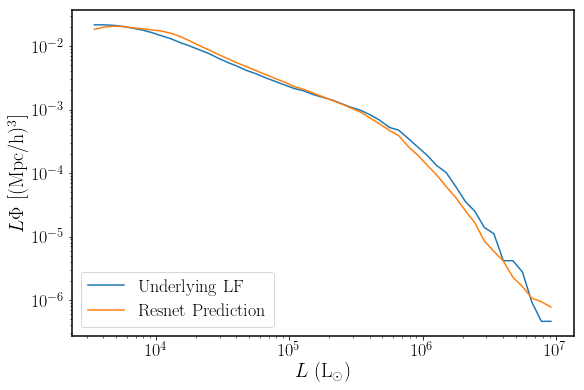

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))

true_lum = 10**cur_lum_good
cnn_guess = 10**cnn_lum_good[0]

plt.plot(lumLogBinCents, true_lum/conv, label='Underlying LF')
plt.plot(lumLogBinCents, cnn_guess/conv, label='Resnet Prediction')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([1,10**5.5])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^3$]')
# # plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend(loc='lower left')

plt.show(ax)
# plt.savefig('../figures/guess_range_good.pdf', bbox_inches='tight')

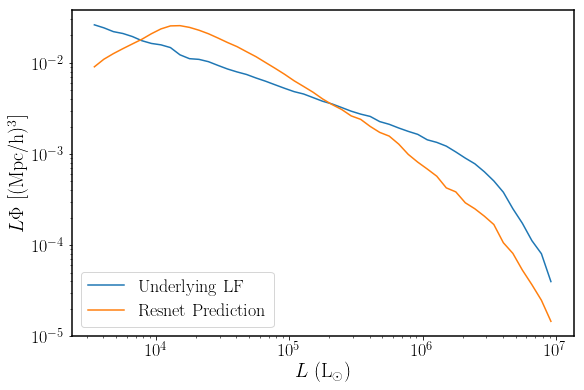

In [19]:
fig, ax = plt.subplots(figsize=(9, 6))

true_lum = 10**cur_lum_Pad
cnn_guess = 10**cnn_lum_Pad[0]

plt.plot(lumLogBinCents, true_lum/conv, label='Underlying LF')
plt.plot(lumLogBinCents, cnn_guess/conv, label='Resnet Prediction')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([1,10**5.5])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^3$]')
# # plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend(loc='lower left')

plt.show(ax)
# plt.savefig('../figures/guess_range_good.pdf', bbox_inches='tight')

0 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13675_rotate_0_subfield_21__Li_-1.817e-02_1.417e+00_-1.828e+00_3.054e-01_2.941e-01 ----------------------------
Error and MSE for the given base_number:
[0.03853805735707283, 0.078942984342575073]


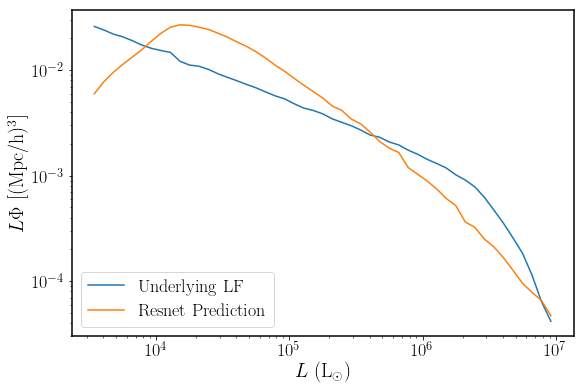

1 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13737_rotate_0_subfield_19__Li_-8.101e-02_1.394e+00_-1.909e+00_3.060e-01_2.917e-01 ----------------------------
Error and MSE for the given base_number:
[0.02045707032084465, 0.04165765643119812]


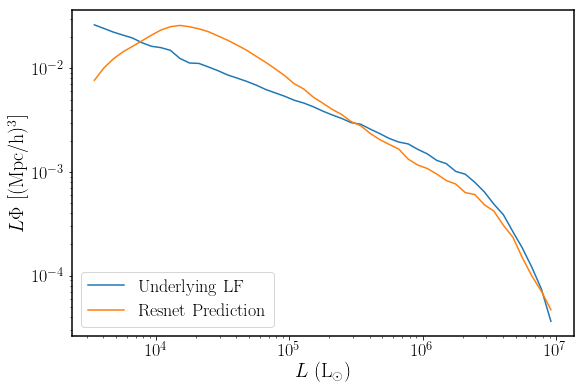

2 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13599_rotate_0_subfield_3__Li_-1.120e-02_1.377e+00_-1.217e+00_3.175e-01_3.047e-01 ----------------------------
Error and MSE for the given base_number:
[0.04583561047911644, 0.094363667070865631]


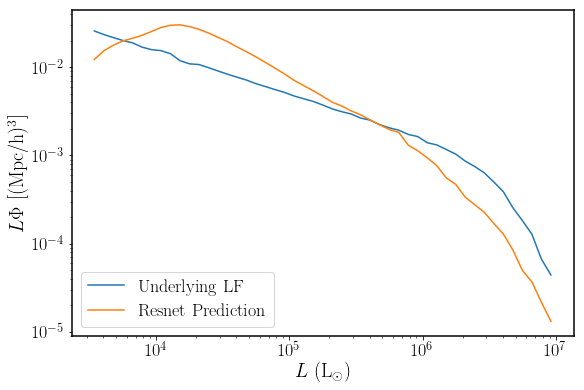

3 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13615_rotate_0_subfield_22__Li_-1.031e-02_1.392e+00_-1.903e+00_3.017e-01_3.150e-01 ----------------------------
Error and MSE for the given base_number:
[0.034764405339956284, 0.07114633172750473]


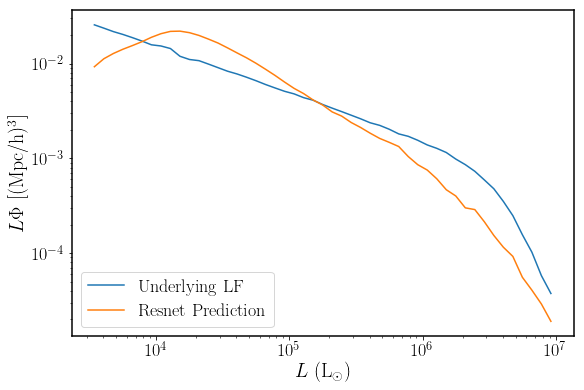

4 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13761_rotate_0_subfield_0__Li_4.074e-02_1.376e+00_-1.770e+00_3.085e-01_2.947e-01 ----------------------------
Error and MSE for the given base_number:
[0.034578021615743637, 0.07097703218460083]


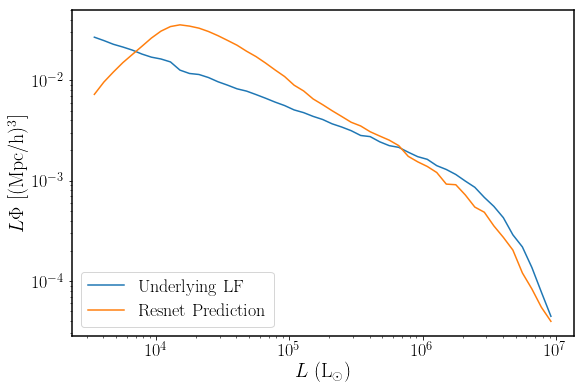

5 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13597_rotate_0_subfield_16__Li_-1.582e-02_1.355e+00_-2.539e+00_2.800e-01_2.937e-01 ----------------------------
Error and MSE for the given base_number:
[0.049676120281219482, 0.10267078876495361]


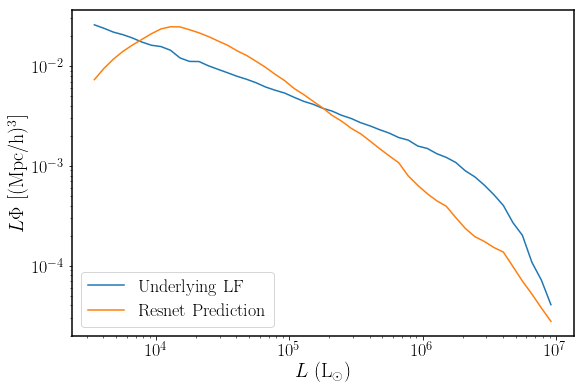

6 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13585_rotate_0_subfield_27__Li_-9.981e-03_1.377e+00_-1.263e+00_3.029e-01_3.073e-01 ----------------------------
Error and MSE for the given base_number:
[0.055871248245239258, 0.11592182517051697]


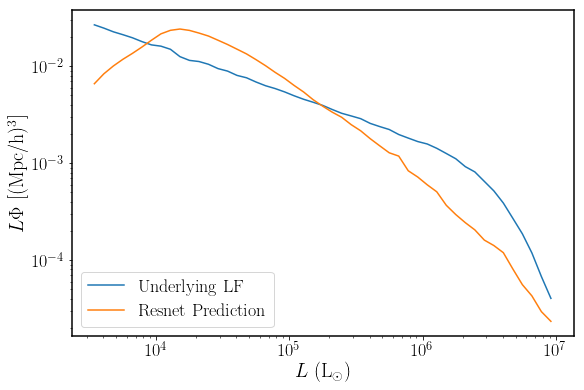

7 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13613_rotate_0_subfield_33__Li_-1.542e-02_1.419e+00_-1.131e+00_2.967e-01_3.012e-01 ----------------------------
Error and MSE for the given base_number:
[0.066621080040931702, 0.14014299213886261]


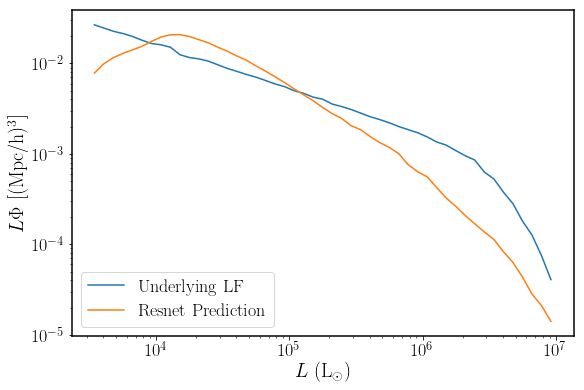

8 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13579_rotate_0_subfield_30__Li_-1.602e-02_1.386e+00_-2.814e+00_3.103e-01_3.038e-01 ----------------------------
Error and MSE for the given base_number:
[0.041605327278375626, 0.085500970482826233]


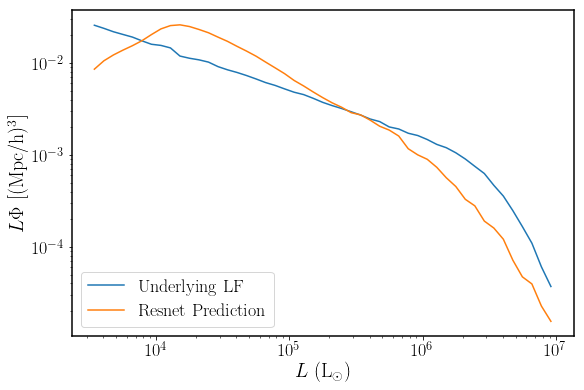

9 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13611_rotate_0_subfield_30__Li_2.900e-02_1.344e+00_-1.786e+00_2.949e-01_3.186e-01 ----------------------------
Error and MSE for the given base_number:
[0.053530856966972351, 0.11070379614830017]


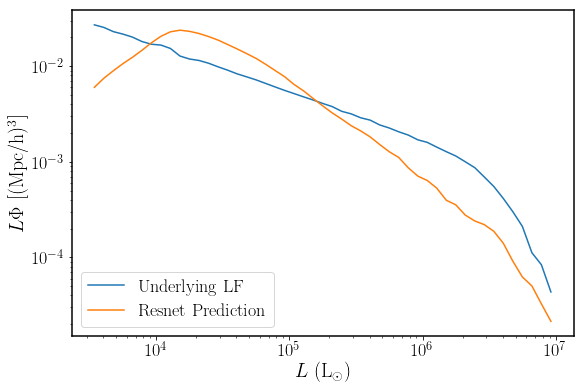

10 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13883_rotate_0_subfield_22__Li_-2.866e-04_1.343e+00_-1.693e+00_3.172e-01_2.932e-01 ----------------------------
Error and MSE for the given base_number:
[0.058860290795564651, 0.12231379747390747]


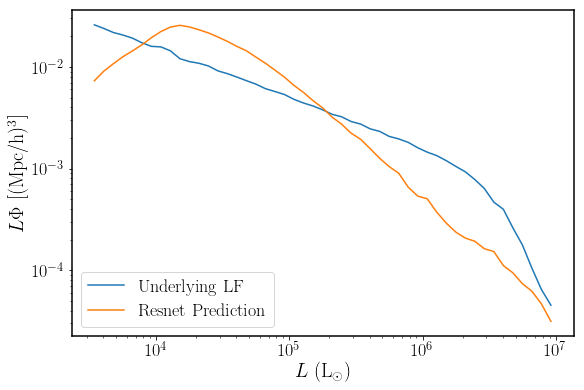

11 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13717_rotate_0_subfield_6__Li_-1.528e-02_1.414e+00_-1.610e+00_3.003e-01_2.951e-01 ----------------------------
Error and MSE for the given base_number:
[0.045580551028251648, 0.093730874359607697]


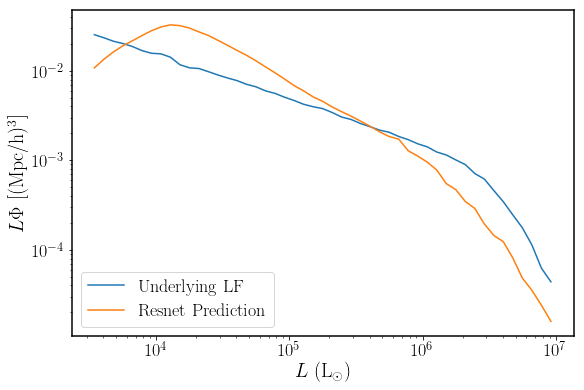

12 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13639_rotate_0_subfield_8__Li_-7.212e-03_1.317e+00_-2.098e+00_2.936e-01_3.028e-01 ----------------------------
Error and MSE for the given base_number:
[0.049717992544174194, 0.10213537514209747]


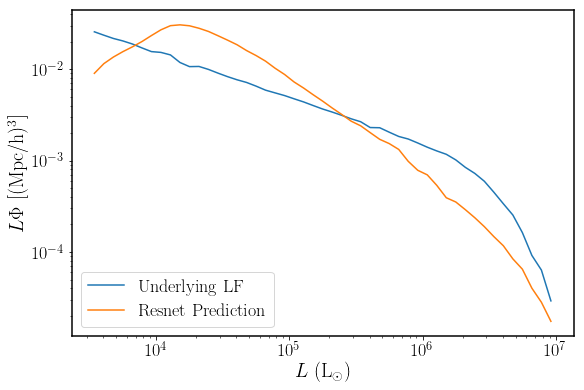

13 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13767_rotate_0_subfield_13__Li_1.285e-02_1.373e+00_-1.387e+00_3.049e-01_3.024e-01 ----------------------------
Error and MSE for the given base_number:
[0.044172968715429306, 0.091885194182395935]


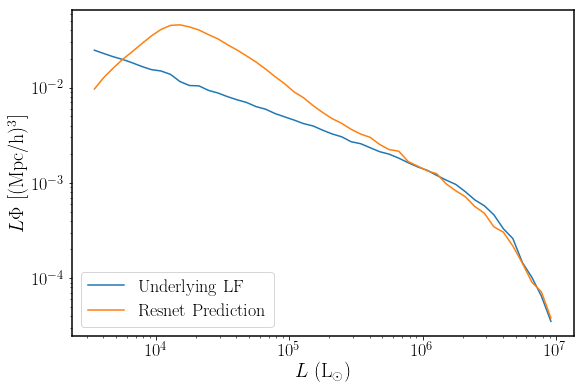

14 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13767_rotate_0_subfield_24__Li_-2.263e-02_1.316e+00_-1.029e+00_2.915e-01_3.003e-01 ----------------------------
Error and MSE for the given base_number:
[0.040448747575283051, 0.082972884178161621]


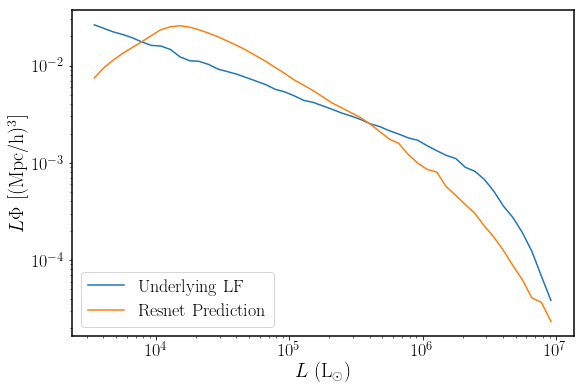

15 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13605_rotate_0_subfield_33__Li_7.962e-03_1.344e+00_-1.584e+00_3.078e-01_3.009e-01 ----------------------------
Error and MSE for the given base_number:
[0.069952502846717834, 0.14684268832206726]


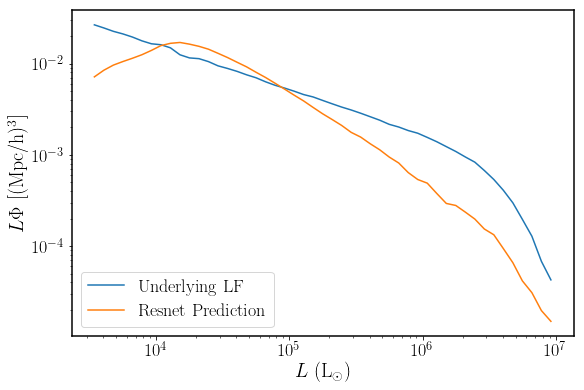

16 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13713_rotate_0_subfield_19__Li_1.602e-02_1.361e+00_-1.852e+00_2.852e-01_2.999e-01 ----------------------------
Error and MSE for the given base_number:
[0.036791659891605377, 0.075708873569965363]


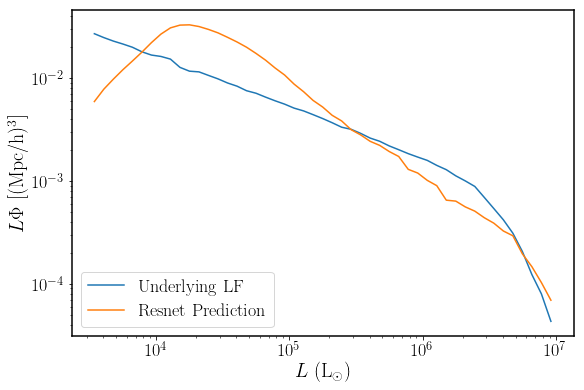

17 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13645_rotate_0_subfield_30__Li_-3.245e-03_1.389e+00_-1.661e+00_2.704e-01_2.838e-01 ----------------------------
Error and MSE for the given base_number:
[0.050756562501192093, 0.10427707433700562]


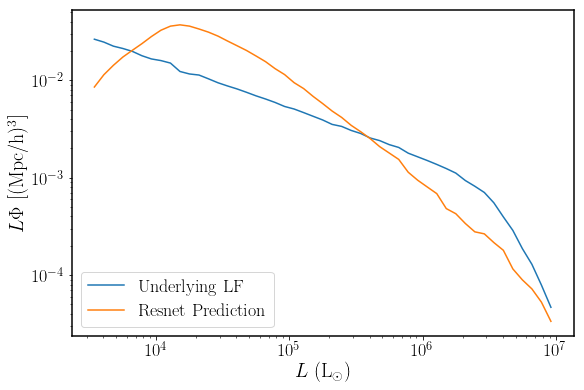

18 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13721_rotate_0_subfield_2__Li_-9.783e-03_1.423e+00_-2.273e+00_2.818e-01_3.019e-01 ----------------------------
Error and MSE for the given base_number:
[0.040885761380195618, 0.0836993008852005]


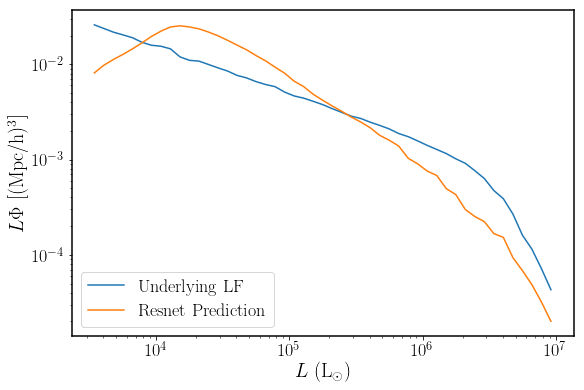

19 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13773_rotate_0_subfield_11__Li_-3.913e-02_1.308e+00_-1.773e+00_2.885e-01_2.916e-01 ----------------------------
Error and MSE for the given base_number:
[0.033191684633493423, 0.067952781915664673]


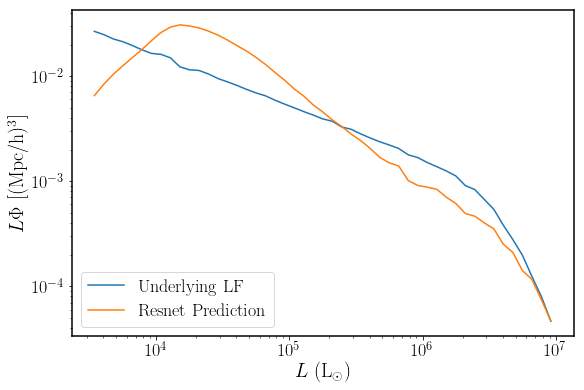

20 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13893_rotate_0_subfield_30__Li_6.510e-02_1.377e+00_-1.253e+00_2.918e-01_2.937e-01 ----------------------------
Error and MSE for the given base_number:
[0.058169383555650711, 0.12127672135829926]


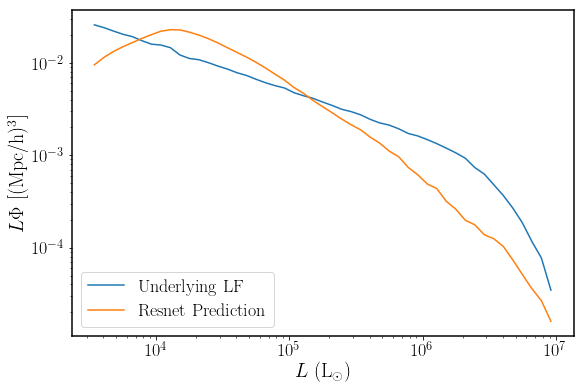

21 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13791_rotate_0_subfield_8__Li_-1.632e-02_1.388e+00_-1.678e+00_3.072e-01_3.119e-01 ----------------------------
Error and MSE for the given base_number:
[0.033135335892438889, 0.067577287554740906]


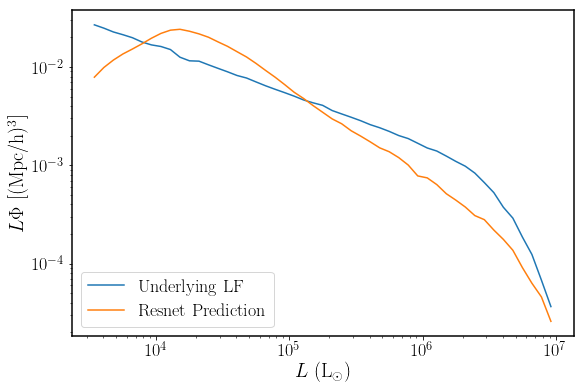

22 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13867_rotate_0_subfield_12__Li_-3.979e-04_1.427e+00_-1.499e+00_2.912e-01_3.041e-01 ----------------------------
Error and MSE for the given base_number:
[0.023791369050741196, 0.04833882674574852]


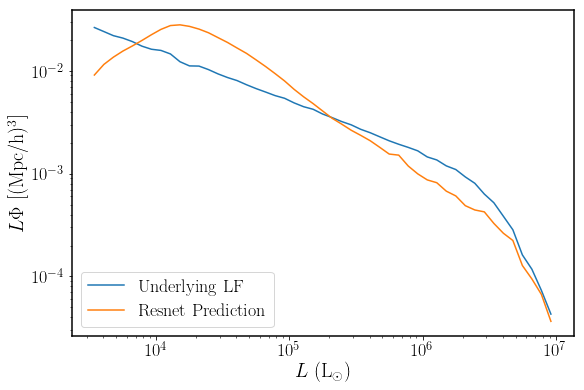

23 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13801_rotate_0_subfield_10__Li_1.246e-02_1.345e+00_-1.639e+00_3.064e-01_3.116e-01 ----------------------------
Error and MSE for the given base_number:
[0.0470537468791008, 0.096669234335422516]


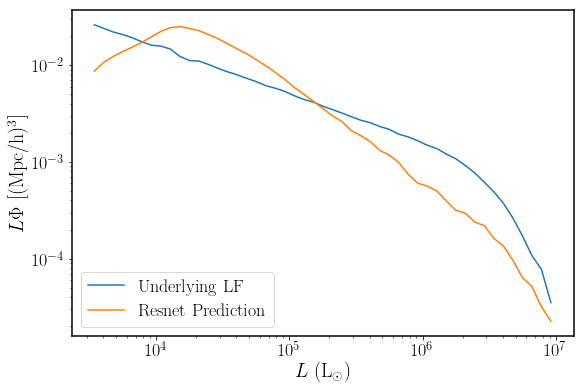

24 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13621_rotate_0_subfield_18__Li_-5.379e-02_1.339e+00_-1.773e+00_2.982e-01_2.960e-01 ----------------------------
Error and MSE for the given base_number:
[0.039708428084850311, 0.081379726529121399]


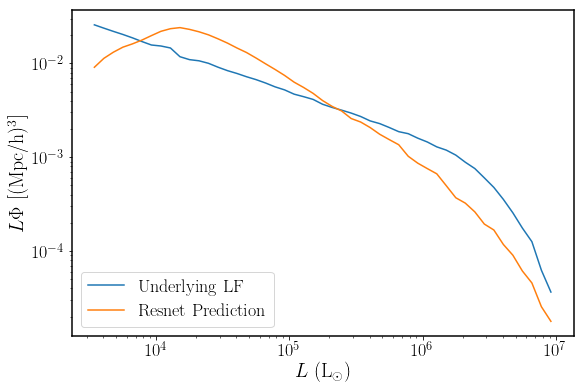

25 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13873_rotate_0_subfield_23__Li_-4.163e-02_1.368e+00_-2.238e+00_3.027e-01_3.001e-01 ----------------------------
Error and MSE for the given base_number:
[0.040235739201307297, 0.082402318716049194]


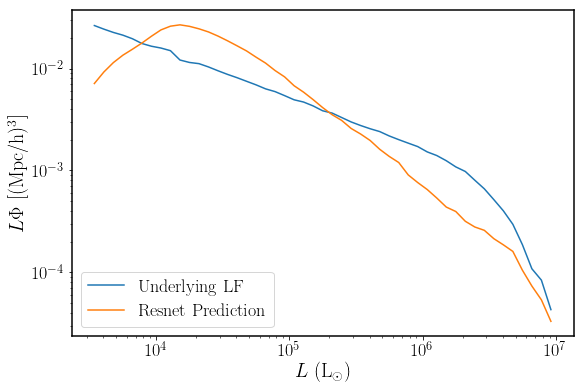

26 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13733_rotate_0_subfield_19__Li_4.151e-03_1.426e+00_-2.149e+00_2.861e-01_2.931e-01 ----------------------------
Error and MSE for the given base_number:
[0.035099167376756668, 0.071576781570911407]


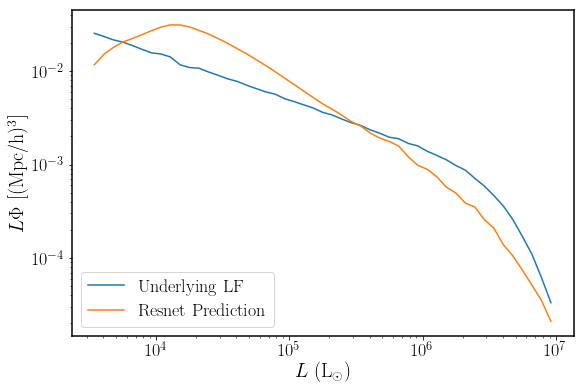

27 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13849_rotate_0_subfield_17__Li_2.297e-02_1.353e+00_-1.993e+00_3.177e-01_3.098e-01 ----------------------------
Error and MSE for the given base_number:
[0.040775038301944733, 0.083746500313282013]


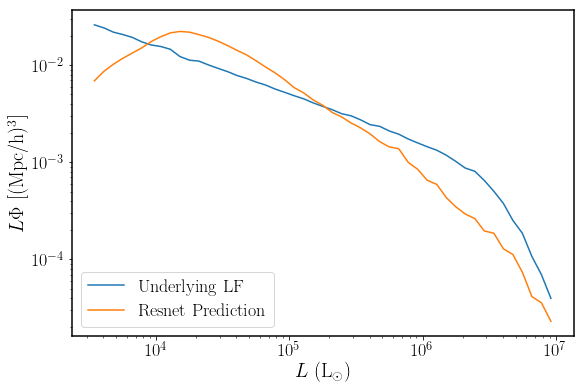

28 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13795_rotate_0_subfield_27__Li_-3.341e-03_1.429e+00_-1.667e+00_2.906e-01_3.088e-01 ----------------------------
Error and MSE for the given base_number:
[0.045204818248748779, 0.092864483594894409]


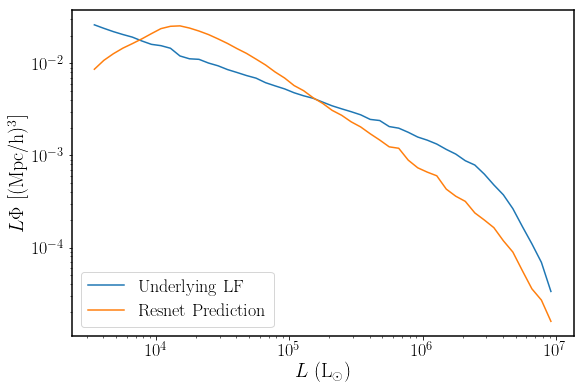

29 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13711_rotate_0_subfield_8__Li_2.240e-02_1.401e+00_-1.389e+00_3.137e-01_2.953e-01 ----------------------------
Error and MSE for the given base_number:
[0.054684463888406754, 0.11329154670238495]


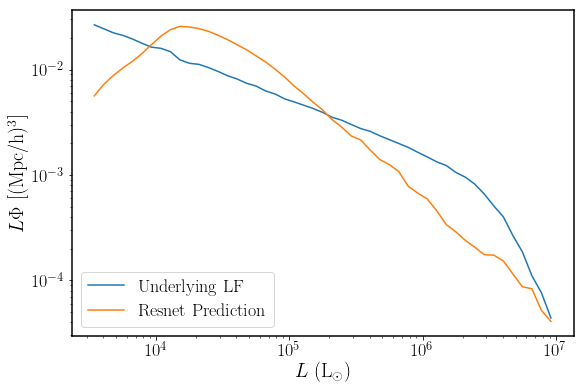

30 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13579_rotate_0_subfield_3__Li_2.531e-03_1.400e+00_-2.129e+00_3.116e-01_3.051e-01 ----------------------------
Error and MSE for the given base_number:
[0.026088595390319824, 0.053271025419235229]


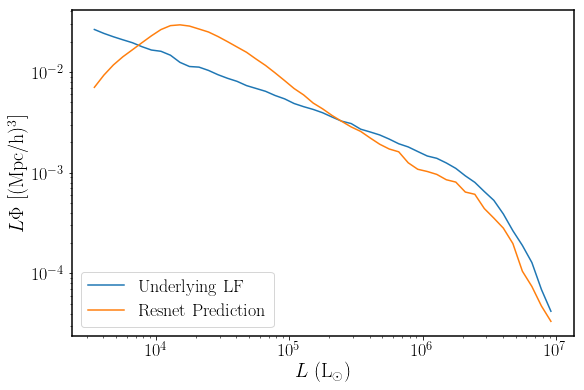

31 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13681_rotate_0_subfield_22__Li_-2.603e-02_1.320e+00_-1.566e+00_2.926e-01_3.024e-01 ----------------------------
Error and MSE for the given base_number:
[0.028001300990581512, 0.057426277548074722]


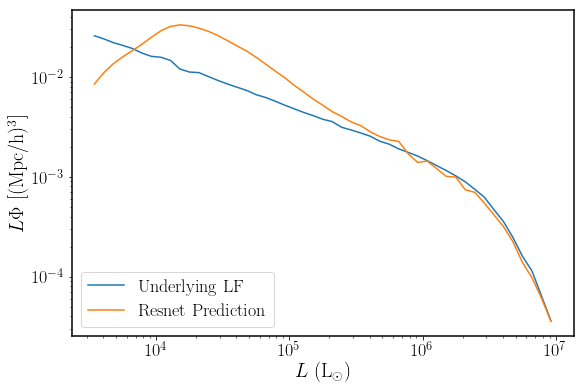

32 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13615_rotate_0_subfield_3__Li_5.149e-02_1.343e+00_-2.221e+00_3.035e-01_3.076e-01 ----------------------------
Error and MSE for the given base_number:
[0.031089145690202713, 0.063394822180271149]


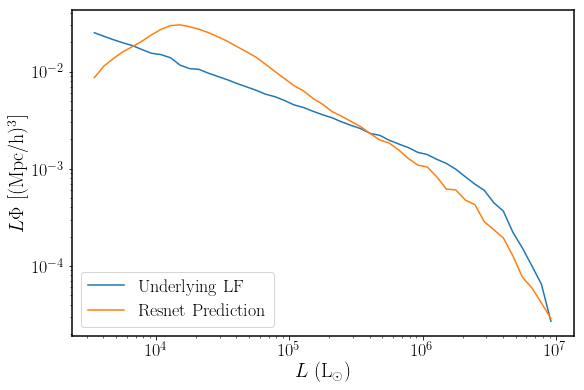

33 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13743_rotate_0_subfield_4__Li_-2.875e-02_1.380e+00_-1.283e+00_3.075e-01_3.071e-01 ----------------------------
Error and MSE for the given base_number:
[0.036130443215370178, 0.074265122413635254]


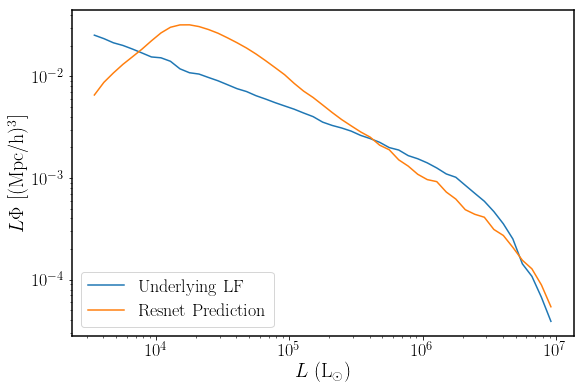

34 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13839_rotate_0_subfield_3__Li_-1.268e-02_1.285e+00_-2.531e+00_2.882e-01_3.068e-01 ----------------------------
Error and MSE for the given base_number:
[0.036820501089096069, 0.075128480792045593]


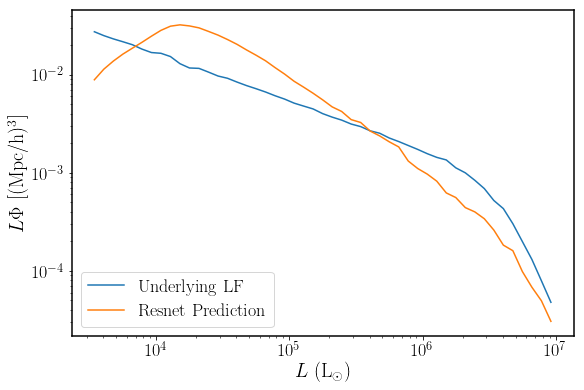

35 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13783_rotate_0_subfield_19__Li_9.717e-03_1.406e+00_-1.560e+00_2.870e-01_2.962e-01 ----------------------------
Error and MSE for the given base_number:
[0.053695715963840485, 0.11099768429994583]


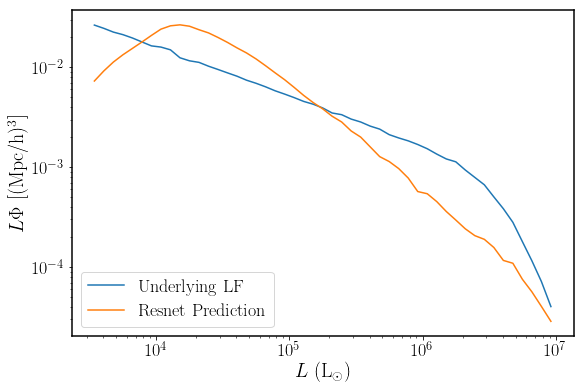

36 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13889_rotate_0_subfield_5__Li_1.061e-02_1.391e+00_-1.466e+00_2.992e-01_2.982e-01 ----------------------------
Error and MSE for the given base_number:
[0.031792797148227692, 0.06483401358127594]


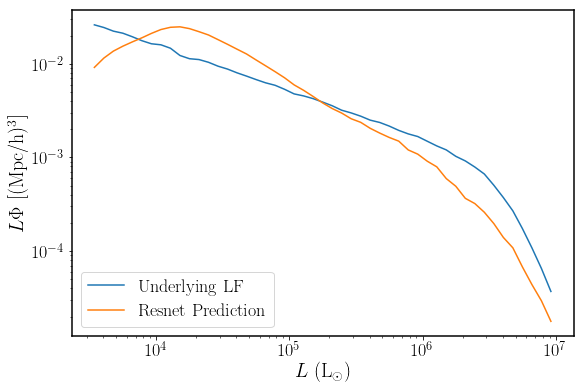

37 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13749_rotate_0_subfield_26__Li_4.021e-02_1.348e+00_-1.459e+00_3.089e-01_2.997e-01 ----------------------------
Error and MSE for the given base_number:
[0.062986172735691071, 0.13168084621429443]


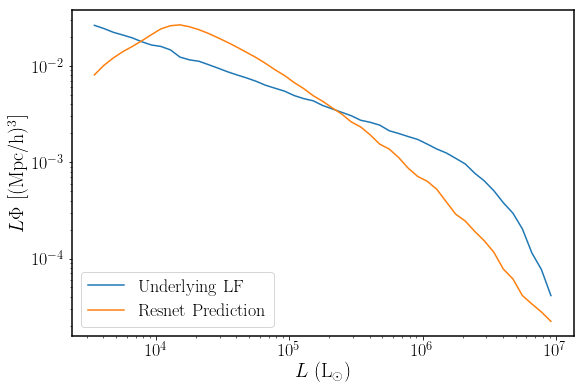

38 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13763_rotate_0_subfield_3__Li_-5.556e-02_1.332e+00_-1.563e+00_3.072e-01_3.041e-01 ----------------------------
Error and MSE for the given base_number:
[0.028455164283514023, 0.05782897025346756]


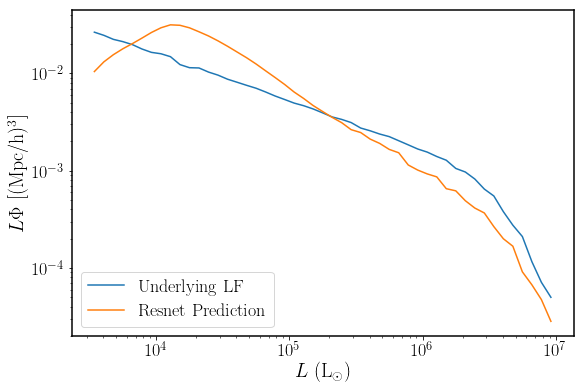

39 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13717_rotate_0_subfield_19__Li_1.309e-02_1.392e+00_-1.834e+00_3.106e-01_2.941e-01 ----------------------------
Error and MSE for the given base_number:
[0.05754103884100914, 0.11985848098993301]


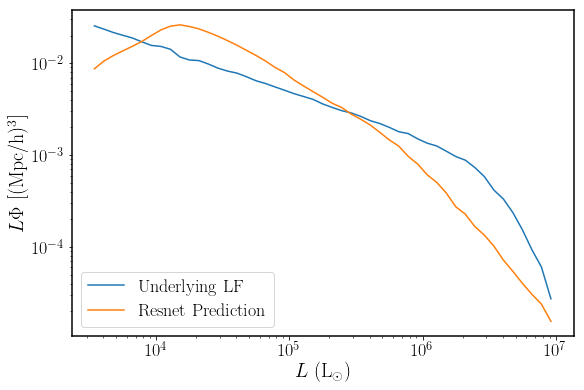

40 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13795_rotate_0_subfield_12__Li_1.198e-02_1.344e+00_-1.543e+00_3.064e-01_2.997e-01 ----------------------------
Error and MSE for the given base_number:
[0.060432150959968567, 0.12577195465564728]


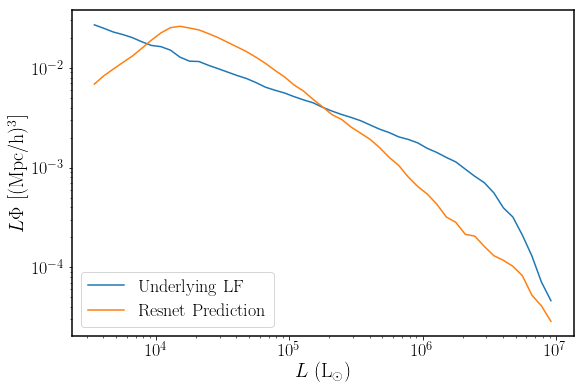

41 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13591_rotate_0_subfield_22__Li_-5.566e-03_1.381e+00_-2.016e+00_3.025e-01_3.055e-01 ----------------------------
Error and MSE for the given base_number:
[0.051606565713882446, 0.10705374926328659]


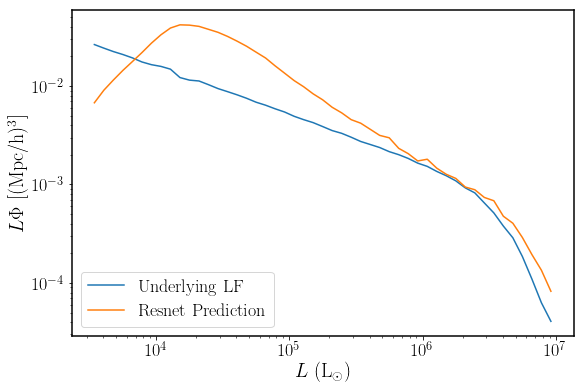

42 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13801_rotate_0_subfield_18__Li_1.330e-02_1.327e+00_-1.890e+00_2.952e-01_2.946e-01 ----------------------------
Error and MSE for the given base_number:
[0.033280536532402039, 0.067825399339199066]


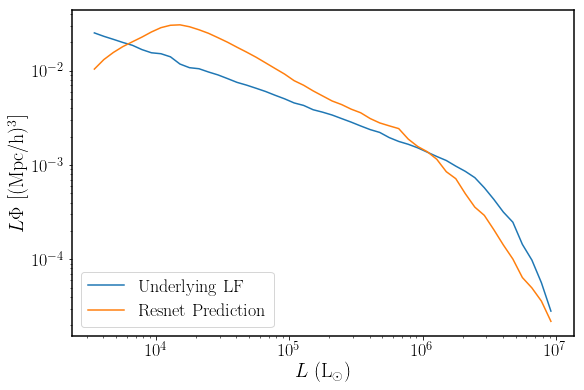

43 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13753_rotate_0_subfield_21__Li_2.663e-02_1.366e+00_-1.692e+00_3.069e-01_3.024e-01 ----------------------------
Error and MSE for the given base_number:
[0.055048465728759766, 0.11399979144334793]


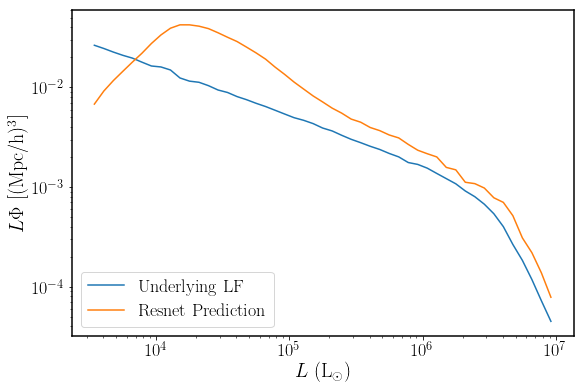

44 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13669_rotate_0_subfield_27__Li_-6.997e-03_1.350e+00_-2.009e+00_3.018e-01_3.058e-01 ----------------------------
Error and MSE for the given base_number:
[0.042323004454374313, 0.087040841579437256]


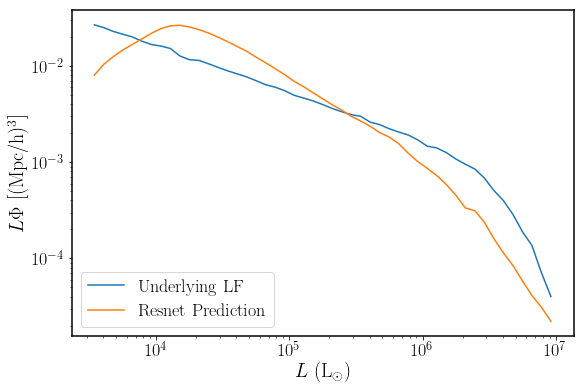

45 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13629_rotate_0_subfield_5__Li_4.275e-03_1.360e+00_-1.962e+00_3.077e-01_3.188e-01 ----------------------------
Error and MSE for the given base_number:
[0.049315996468067169, 0.10150651633739471]


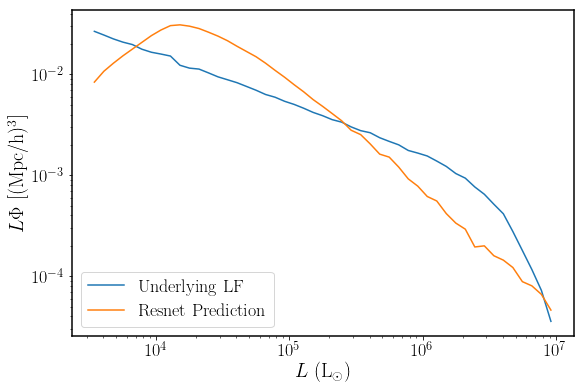

46 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13811_rotate_0_subfield_0__Li_1.689e-02_1.367e+00_-1.327e+00_3.001e-01_3.142e-01 ----------------------------
Error and MSE for the given base_number:
[0.04646633192896843, 0.096310898661613464]


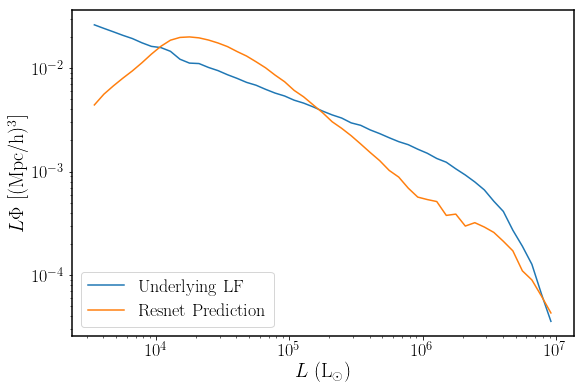

47 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13845_rotate_0_subfield_24__Li_5.547e-04_1.345e+00_-1.577e+00_3.058e-01_3.067e-01 ----------------------------
Error and MSE for the given base_number:
[0.05065600574016571, 0.10452716052532196]


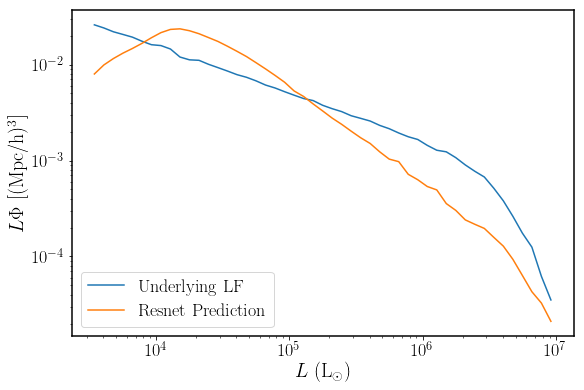

48 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13899_rotate_0_subfield_3__Li_4.082e-03_1.369e+00_-1.590e+00_3.037e-01_3.052e-01 ----------------------------
Error and MSE for the given base_number:
[0.044928077608346939, 0.092424161732196808]


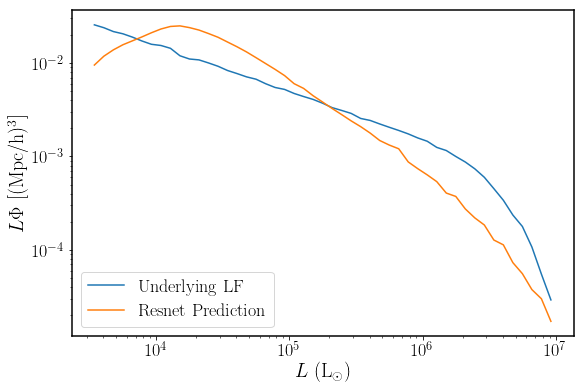

49 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13813_rotate_0_subfield_9__Li_4.221e-03_1.377e+00_-2.355e+00_2.983e-01_3.173e-01 ----------------------------
Error and MSE for the given base_number:
[0.058598879724740982, 0.12198003381490707]


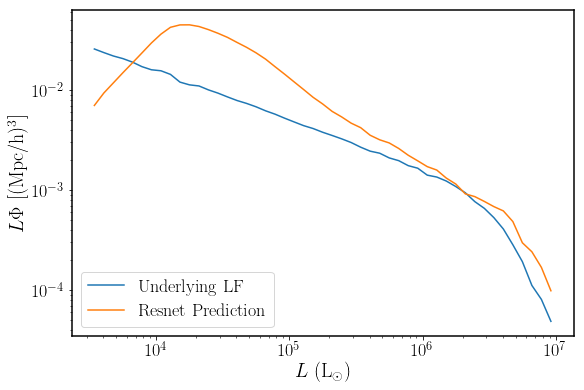

50 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13663_rotate_0_subfield_13__Li_-2.020e-02_1.292e+00_-1.774e+00_2.899e-01_2.996e-01 ----------------------------
Error and MSE for the given base_number:
[0.039122864603996277, 0.080007731914520264]


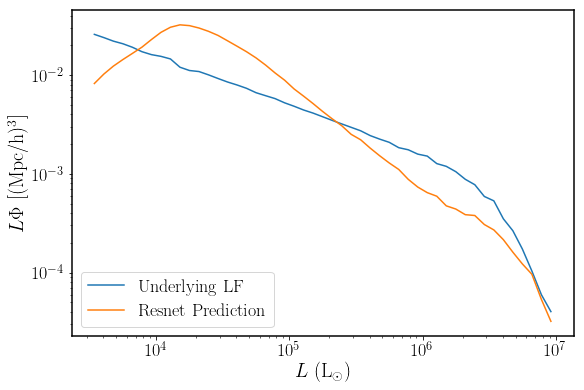

51 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13747_rotate_0_subfield_15__Li_-1.023e-02_1.377e+00_-9.954e-01_2.902e-01_2.922e-01 ----------------------------
Error and MSE for the given base_number:
[0.050188403576612473, 0.10415493696928024]


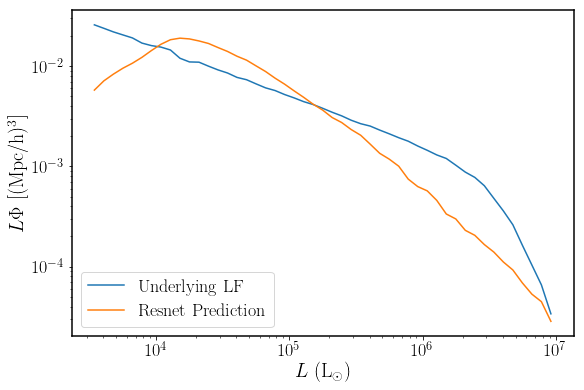

52 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13785_rotate_0_subfield_35__Li_1.784e-02_1.324e+00_-1.860e+00_3.047e-01_3.083e-01 ----------------------------
Error and MSE for the given base_number:
[0.083872735500335693, 0.17872524261474609]


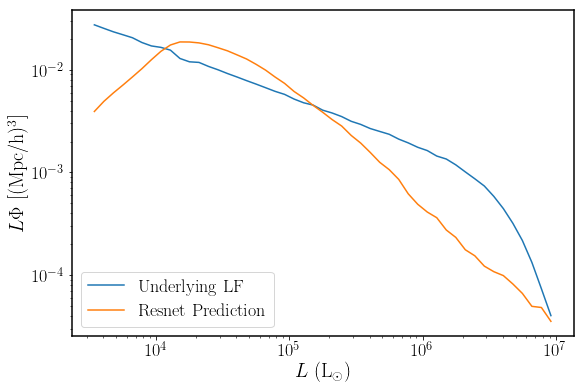

53 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13667_rotate_0_subfield_5__Li_-2.370e-02_1.387e+00_-1.773e+00_2.942e-01_3.014e-01 ----------------------------
Error and MSE for the given base_number:
[0.049420338124036789, 0.10197284072637558]


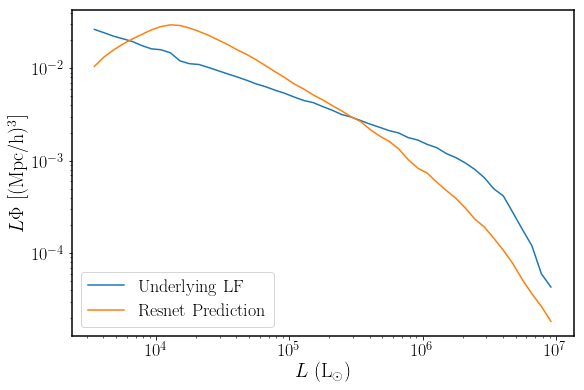

54 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13863_rotate_0_subfield_4__Li_-3.225e-02_1.421e+00_-2.745e+00_3.008e-01_3.103e-01 ----------------------------
Error and MSE for the given base_number:
[0.068595647811889648, 0.14472809433937073]


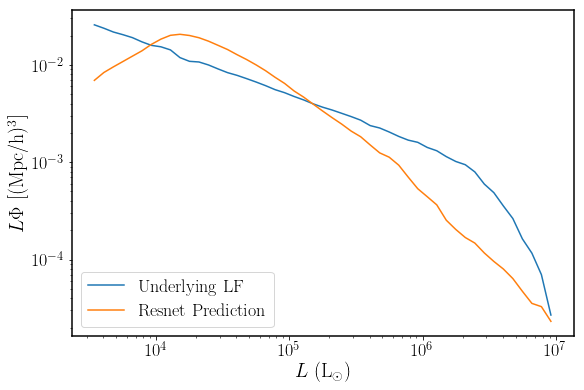

55 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13783_rotate_0_subfield_1__Li_-2.776e-02_1.360e+00_-1.060e+00_3.179e-01_3.205e-01 ----------------------------
Error and MSE for the given base_number:
[0.034712441265583038, 0.070808917284011841]


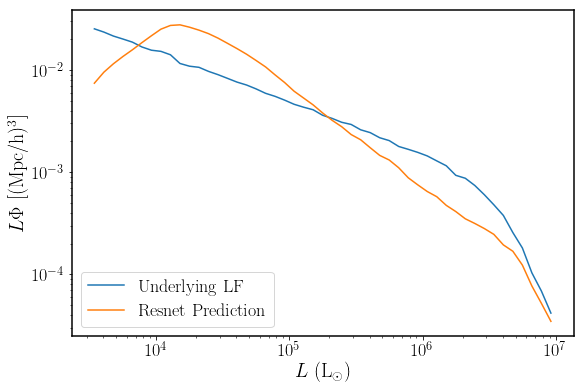

56 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13609_rotate_0_subfield_28__Li_2.098e-02_1.392e+00_-1.728e+00_2.946e-01_2.991e-01 ----------------------------
Error and MSE for the given base_number:
[0.072099409997463226, 0.15376392006874084]


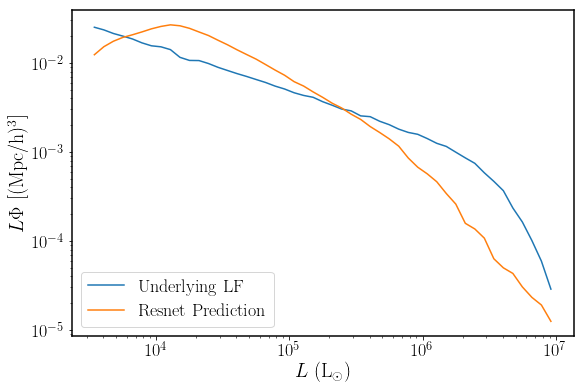

57 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13637_rotate_0_subfield_5__Li_-5.592e-02_1.439e+00_-1.193e+00_3.000e-01_2.849e-01 ----------------------------
Error and MSE for the given base_number:
[0.048685122281312943, 0.10061101615428925]


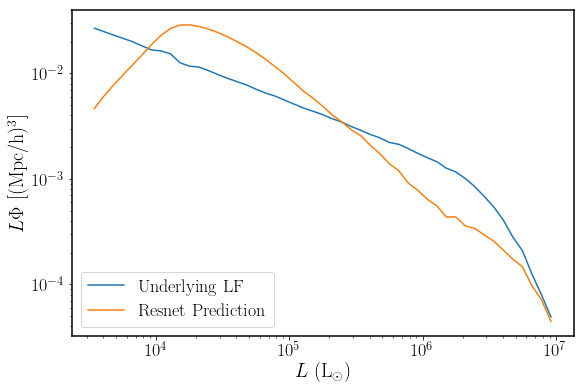

58 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13721_rotate_0_subfield_20__Li_1.255e-02_1.398e+00_-1.255e+00_2.935e-01_3.068e-01 ----------------------------
Error and MSE for the given base_number:
[0.03732021152973175, 0.076548777520656586]


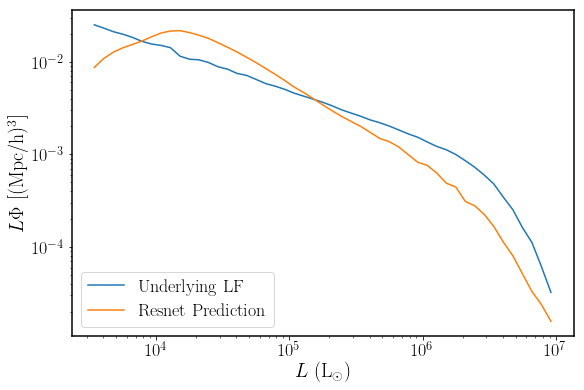

59 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13807_rotate_0_subfield_33__Li_-1.925e-02_1.396e+00_-1.970e+00_2.951e-01_2.829e-01 ----------------------------
Error and MSE for the given base_number:
[0.025125410407781601, 0.051019005477428436]


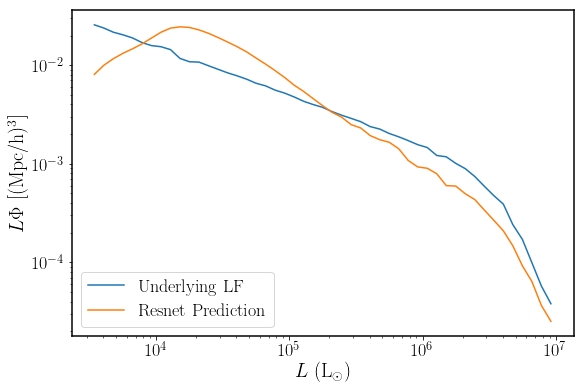

60 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13801_rotate_0_subfield_28__Li_2.147e-03_1.360e+00_-1.797e+00_3.089e-01_2.714e-01 ----------------------------
Error and MSE for the given base_number:
[0.057058878242969513, 0.11875241994857788]


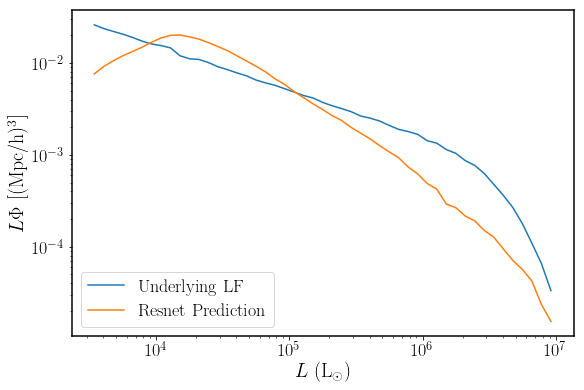

61 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13867_rotate_0_subfield_22__Li_-2.731e-02_1.306e+00_-2.112e+00_3.143e-01_3.026e-01 ----------------------------
Error and MSE for the given base_number:
[0.070047475397586823, 0.14932480454444885]


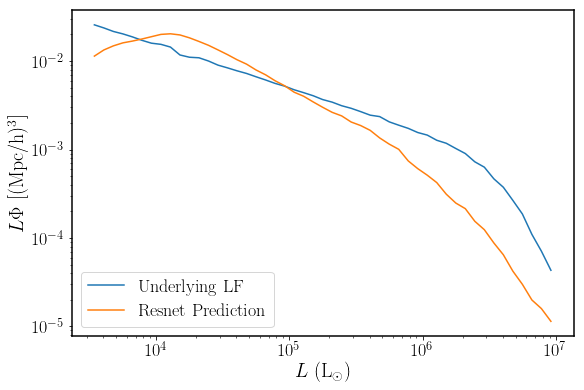

62 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13673_rotate_0_subfield_14__Li_1.337e-02_1.402e+00_-1.749e+00_2.924e-01_2.999e-01 ----------------------------
Error and MSE for the given base_number:
[0.049455925822257996, 0.10198321938514709]


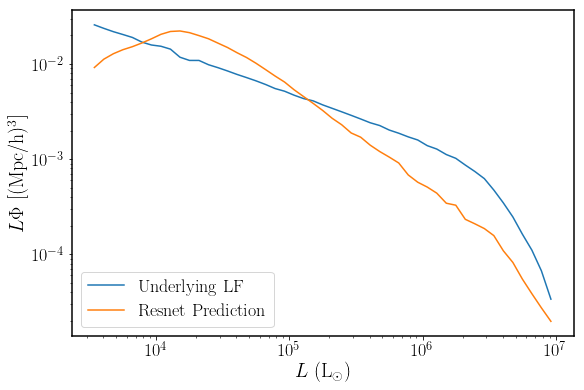

63 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13747_rotate_0_subfield_3__Li_-1.896e-02_1.331e+00_-1.811e+00_3.097e-01_3.065e-01 ----------------------------
Error and MSE for the given base_number:
[0.033575203269720078, 0.068509370088577271]


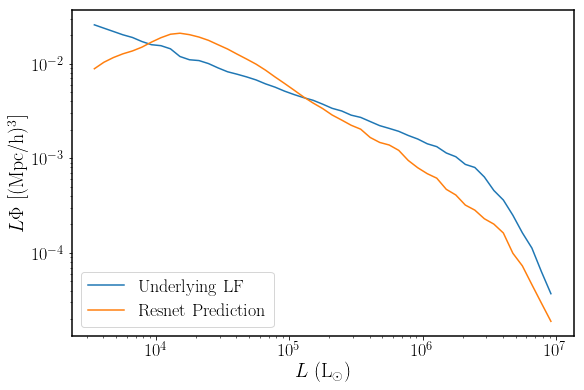

64 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13657_rotate_0_subfield_11__Li_-1.197e-02_1.378e+00_-1.252e+00_3.074e-01_3.025e-01 ----------------------------
Error and MSE for the given base_number:
[0.16164085268974304, 0.36703005433082581]


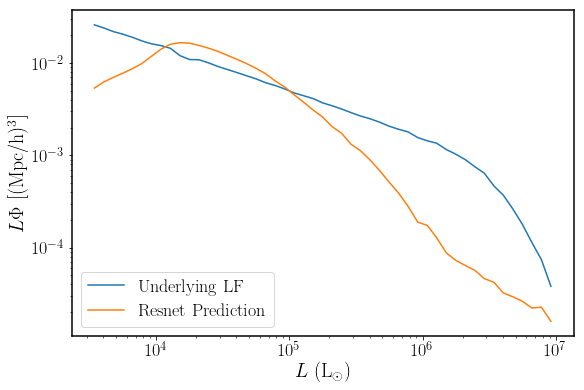

65 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13863_rotate_0_subfield_26__Li_1.179e-02_1.335e+00_-1.540e+00_2.819e-01_2.916e-01 ----------------------------
Error and MSE for the given base_number:
[0.083067446947097778, 0.17746850848197937]


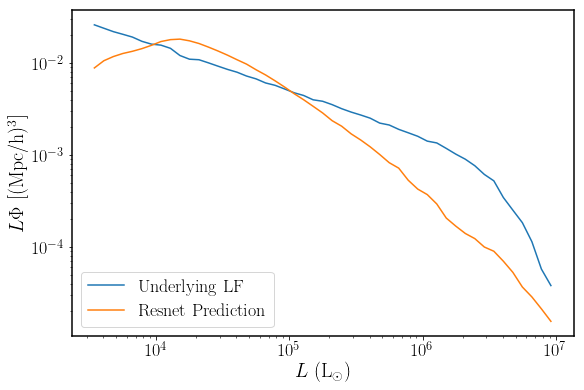

66 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13691_rotate_0_subfield_1__Li_1.355e-02_1.380e+00_-1.960e+00_2.988e-01_3.019e-01 ----------------------------
Error and MSE for the given base_number:
[0.050924275070428848, 0.1055767685174942]


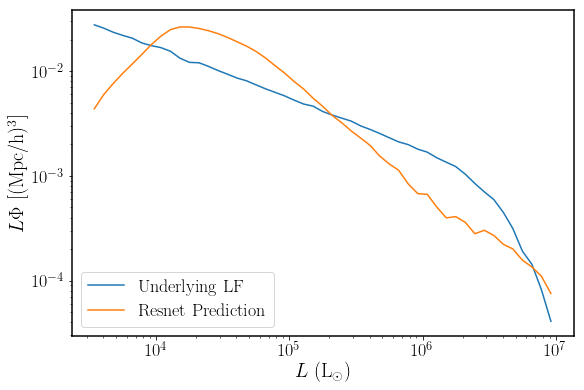

67 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13693_rotate_0_subfield_18__Li_-8.450e-02_1.441e+00_-1.604e+00_3.180e-01_2.896e-01 ----------------------------
Error and MSE for the given base_number:
[0.033594325184822083, 0.068704776465892792]


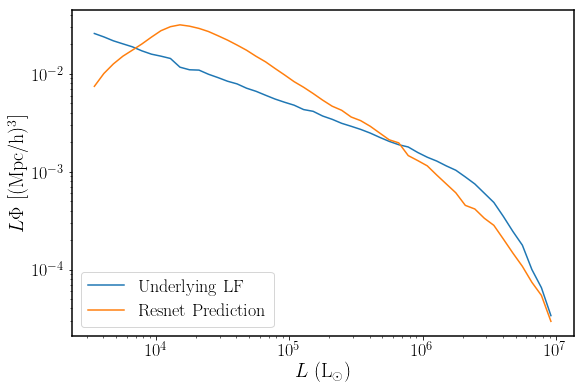

68 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13719_rotate_0_subfield_10__Li_2.229e-03_1.440e+00_-1.375e+00_3.036e-01_2.881e-01 ----------------------------
Error and MSE for the given base_number:
[0.051009856164455414, 0.10501015931367874]


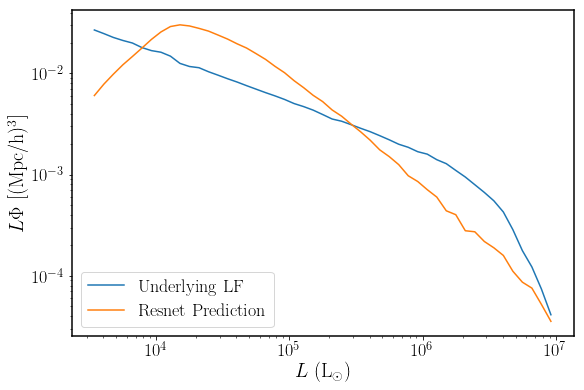

69 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13793_rotate_0_subfield_25__Li_1.543e-02_1.332e+00_-1.577e+00_2.903e-01_3.072e-01 ----------------------------
Error and MSE for the given base_number:
[0.043431475758552551, 0.089642398059368134]


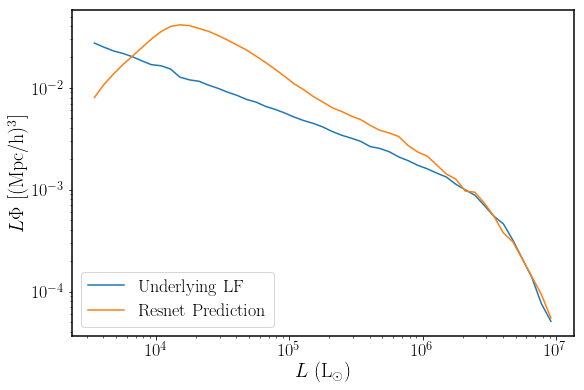

70 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13883_rotate_0_subfield_13__Li_-8.279e-03_1.372e+00_-1.851e+00_3.019e-01_3.145e-01 ----------------------------
Error and MSE for the given base_number:
[0.082155518233776093, 0.17464147508144379]


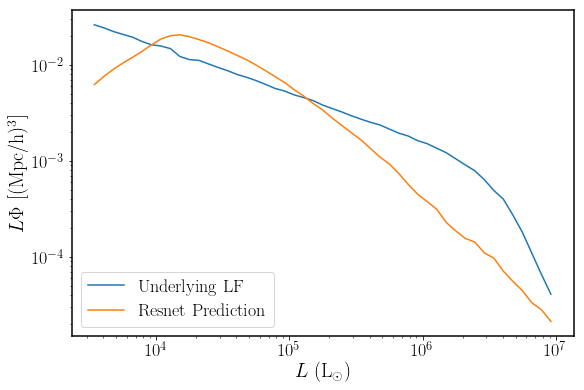

71 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13811_rotate_0_subfield_19__Li_-1.844e-02_1.388e+00_-1.843e+00_3.086e-01_2.874e-01 ----------------------------
Error and MSE for the given base_number:
[0.036949150264263153, 0.075467675924301147]


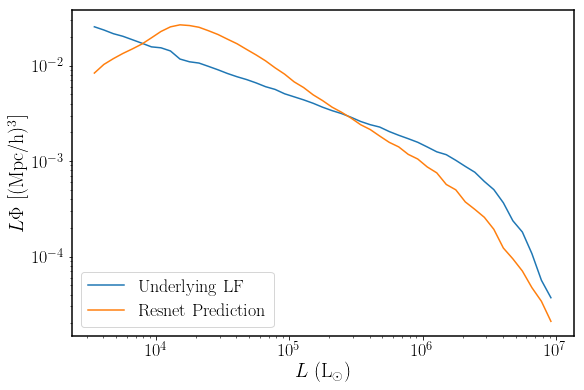

72 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13747_rotate_0_subfield_20__Li_-3.946e-02_1.329e+00_-1.661e+00_2.967e-01_2.864e-01 ----------------------------
Error and MSE for the given base_number:
[0.030911339446902275, 0.063102729618549347]


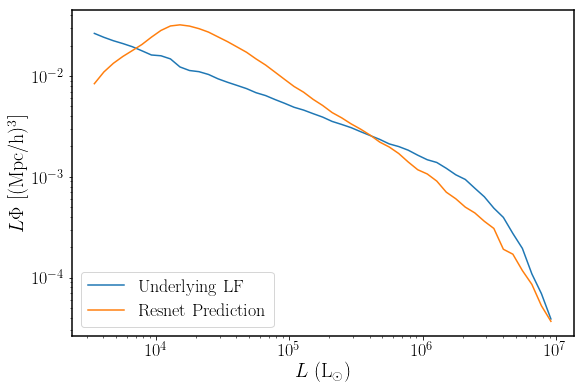

73 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13627_rotate_0_subfield_3__Li_-2.326e-03_1.366e+00_-1.694e+00_2.932e-01_3.005e-01 ----------------------------
Error and MSE for the given base_number:
[0.026549901813268661, 0.053996901959180832]


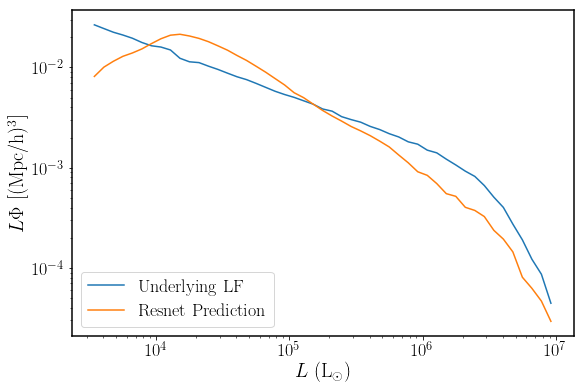

74 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13695_rotate_0_subfield_10__Li_6.522e-02_1.308e+00_-1.514e+00_3.097e-01_2.968e-01 ----------------------------
Error and MSE for the given base_number:
[0.038080692291259766, 0.078391343355178833]


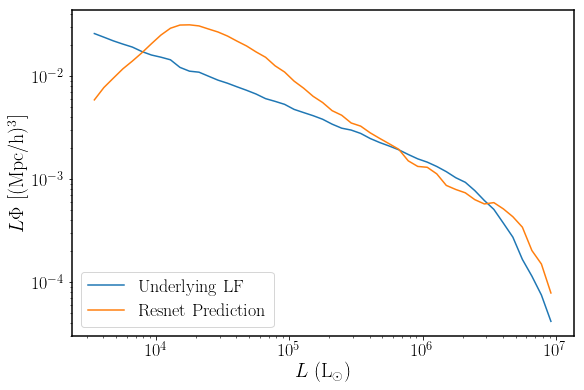

75 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13723_rotate_0_subfield_15__Li_6.633e-03_1.321e+00_-1.331e+00_3.023e-01_3.147e-01 ----------------------------
Error and MSE for the given base_number:
[0.081333532929420471, 0.17401306331157684]


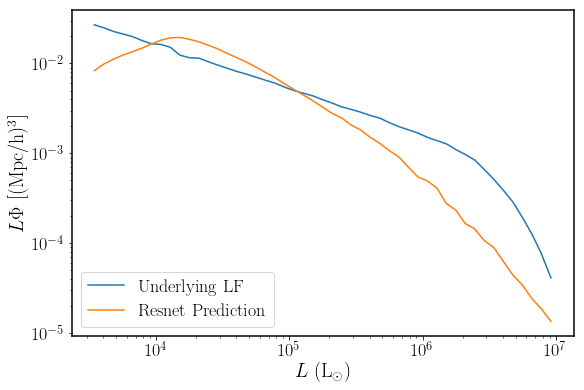

76 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13749_rotate_0_subfield_2__Li_-3.792e-02_1.388e+00_-2.145e+00_3.105e-01_3.009e-01 ----------------------------
Error and MSE for the given base_number:
[0.043954260647296906, 0.090552911162376404]


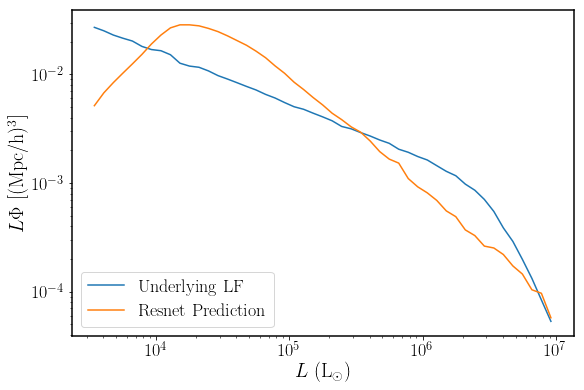

77 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13655_rotate_0_subfield_24__Li_-3.267e-02_1.363e+00_-1.199e+00_2.893e-01_2.898e-01 ----------------------------
Error and MSE for the given base_number:
[0.050732087343931198, 0.10484915971755981]


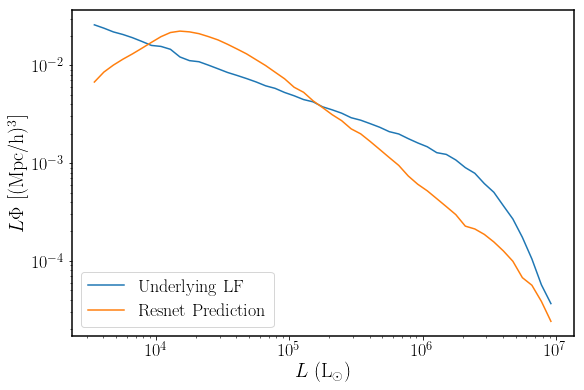

78 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13713_rotate_0_subfield_10__Li_2.376e-02_1.372e+00_-1.083e+00_3.101e-01_3.084e-01 ----------------------------
Error and MSE for the given base_number:
[0.078693918883800507, 0.16843129694461823]


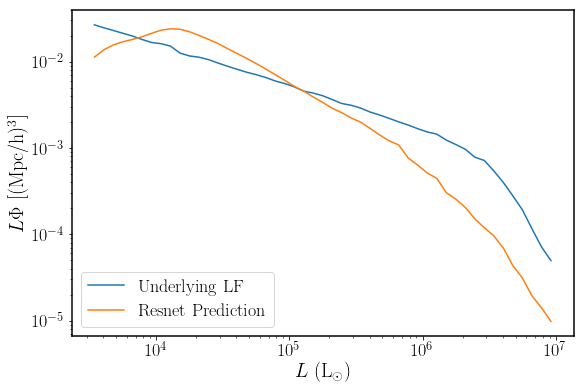

79 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13665_rotate_0_subfield_3__Li_1.647e-02_1.397e+00_-1.518e+00_2.994e-01_3.013e-01 ----------------------------
Error and MSE for the given base_number:
[0.036805585026741028, 0.075174771249294281]


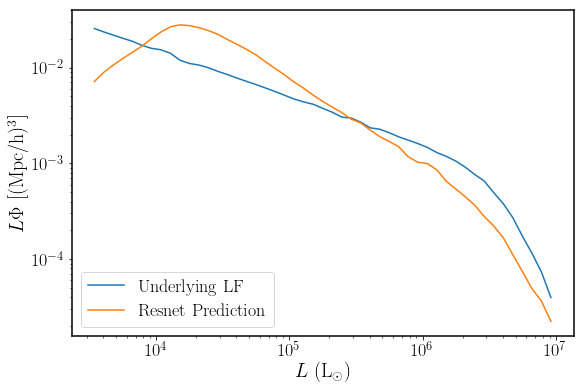

80 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13671_rotate_0_subfield_11__Li_-2.507e-02_1.405e+00_-2.019e+00_3.086e-01_3.042e-01 ----------------------------
Error and MSE for the given base_number:
[0.050756514072418213, 0.10534834116697311]


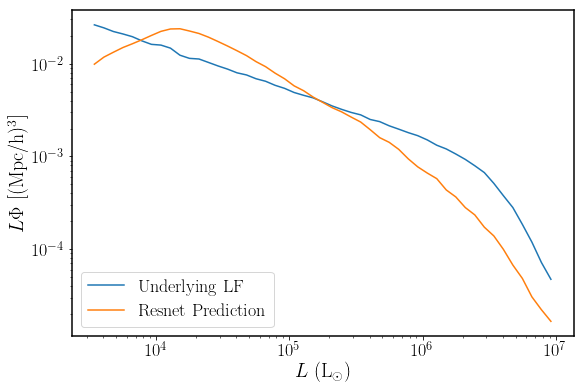

81 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13723_rotate_0_subfield_2__Li_1.110e-02_1.427e+00_-1.870e+00_3.137e-01_2.866e-01 ----------------------------
Error and MSE for the given base_number:
[0.059437375515699387, 0.12302205711603165]


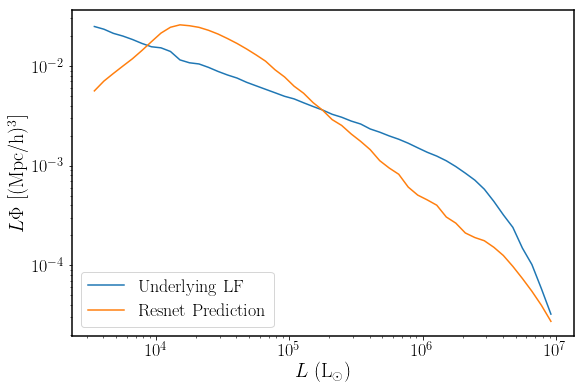

82 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13579_rotate_0_subfield_10__Li_-1.704e-02_1.379e+00_-2.105e+00_3.047e-01_2.956e-01 ----------------------------
Error and MSE for the given base_number:
[0.027083618566393852, 0.055149335414171219]


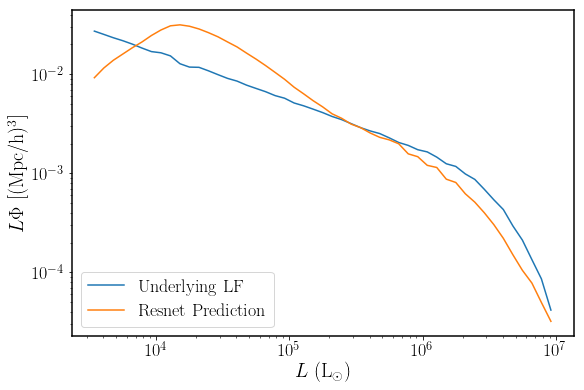

83 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13765_rotate_0_subfield_8__Li_1.068e-02_1.375e+00_-1.360e+00_3.001e-01_2.921e-01 ----------------------------
Error and MSE for the given base_number:
[0.070979587733745575, 0.14905914664268494]


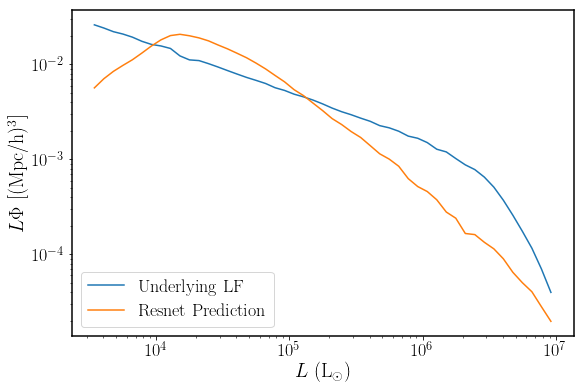

84 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13863_rotate_0_subfield_12__Li_-1.680e-02_1.360e+00_-1.990e+00_2.843e-01_3.068e-01 ----------------------------
Error and MSE for the given base_number:
[0.04418424516916275, 0.090572603046894073]


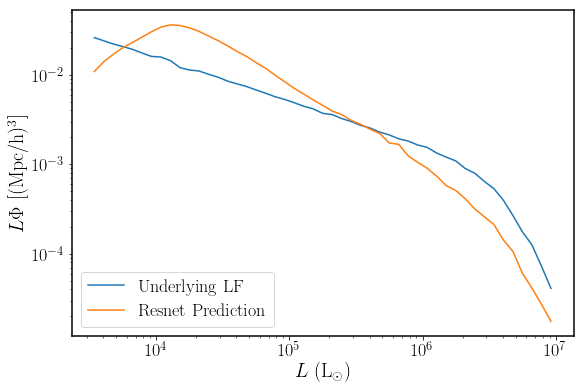

85 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13705_rotate_0_subfield_6__Li_-2.913e-02_1.322e+00_-1.797e+00_2.913e-01_3.241e-01 ----------------------------
Error and MSE for the given base_number:
[0.051198769360780716, 0.10568081587553024]


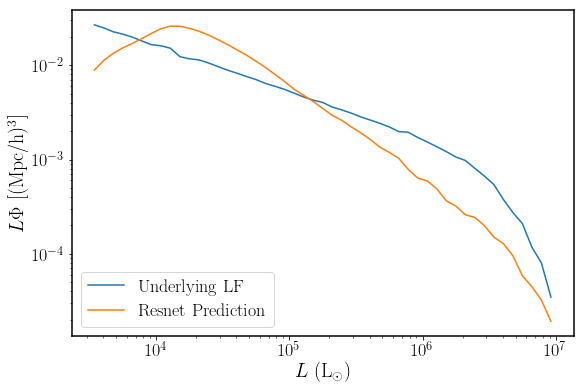

86 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13809_rotate_0_subfield_23__Li_-1.444e-02_1.373e+00_-1.711e+00_3.054e-01_3.093e-01 ----------------------------
Error and MSE for the given base_number:
[0.050052165985107422, 0.10379496216773987]


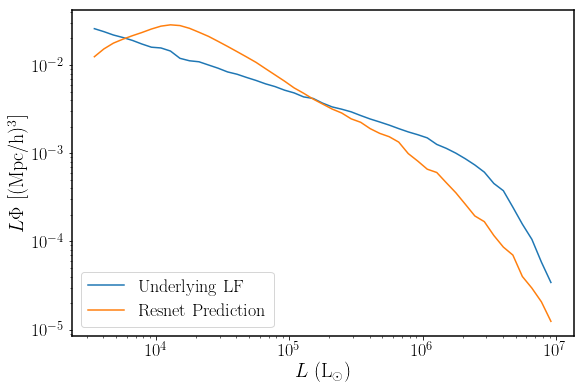

87 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13711_rotate_0_subfield_17__Li_-5.906e-03_1.337e+00_-1.627e+00_2.920e-01_2.920e-01 ----------------------------
Error and MSE for the given base_number:
[0.043718311935663223, 0.08954138308763504]


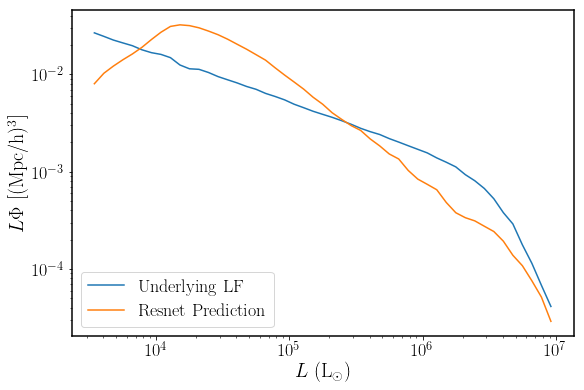

88 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13657_rotate_0_subfield_19__Li_-1.585e-02_1.401e+00_-1.430e+00_2.940e-01_3.046e-01 ----------------------------
Error and MSE for the given base_number:
[0.038778834044933319, 0.079625636339187622]


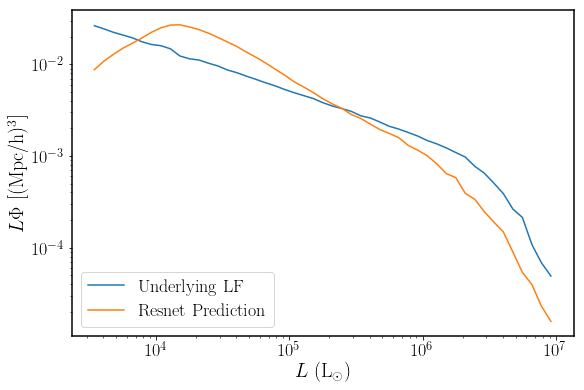

89 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13875_rotate_0_subfield_27__Li_-4.803e-03_1.320e+00_-1.501e+00_2.814e-01_2.890e-01 ----------------------------
Error and MSE for the given base_number:
[0.031451541930437088, 0.064609929919242859]


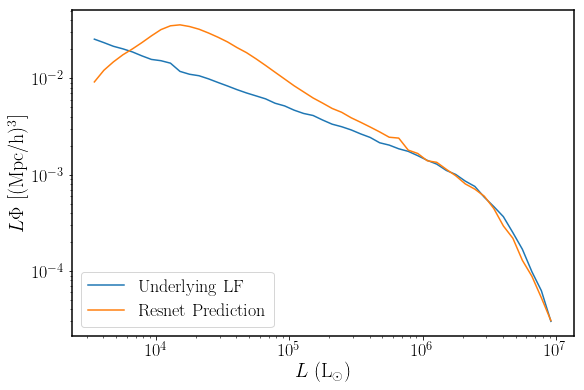

90 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13729_rotate_0_subfield_11__Li_8.435e-03_1.391e+00_-1.856e+00_2.789e-01_2.976e-01 ----------------------------
Error and MSE for the given base_number:
[0.041573312133550644, 0.085483953356742859]


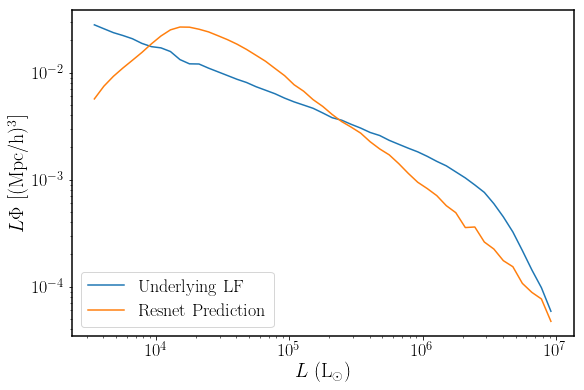

91 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13715_rotate_0_subfield_34__Li_3.306e-02_1.423e+00_-1.894e+00_2.990e-01_2.962e-01 ----------------------------
Error and MSE for the given base_number:
[0.070658266544342041, 0.14928345382213593]


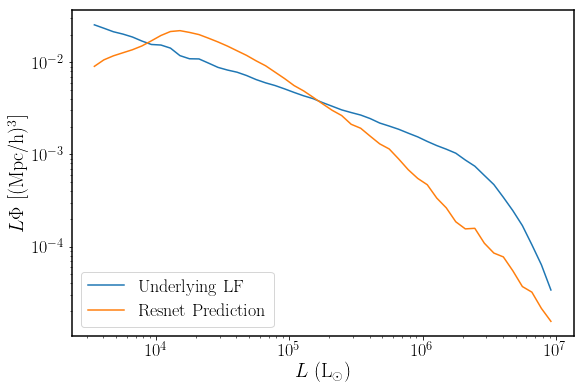

92 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13661_rotate_0_subfield_34__Li_5.974e-03_1.369e+00_-1.726e+00_3.036e-01_3.153e-01 ----------------------------
Error and MSE for the given base_number:
[0.042596090584993362, 0.087700612843036652]


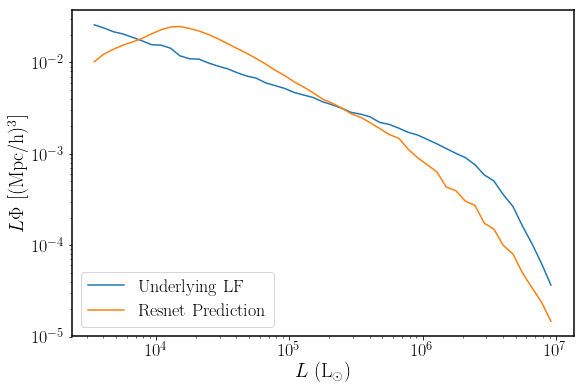

93 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13679_rotate_0_subfield_19__Li_1.073e-03_1.351e+00_-1.618e+00_2.957e-01_3.014e-01 ----------------------------
Error and MSE for the given base_number:
[0.031355321407318115, 0.063902564346790314]


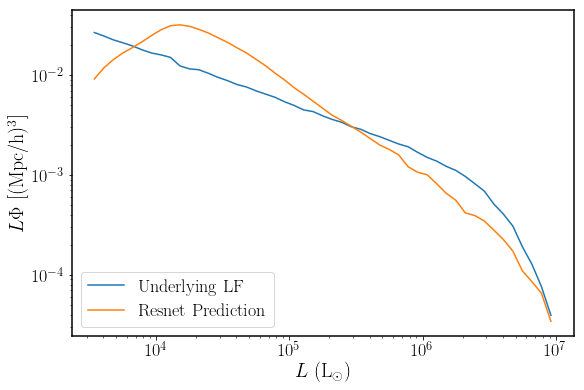

94 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13711_rotate_0_subfield_12__Li_-8.467e-03_1.388e+00_-1.944e+00_2.886e-01_2.932e-01 ----------------------------
Error and MSE for the given base_number:
[0.04823288694024086, 0.099428229033946991]


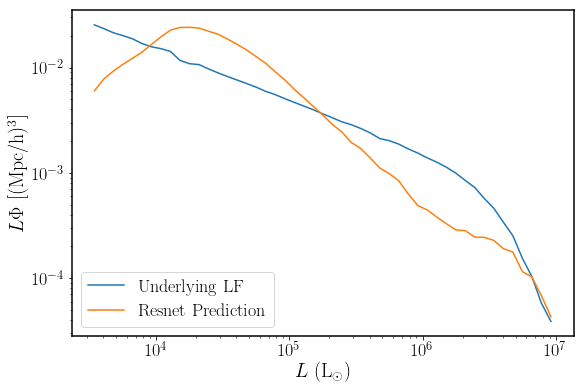

95 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13783_rotate_0_subfield_17__Li_-2.371e-02_1.344e+00_-1.112e+00_2.998e-01_3.177e-01 ----------------------------
Error and MSE for the given base_number:
[0.15701954066753387, 0.35482701659202576]


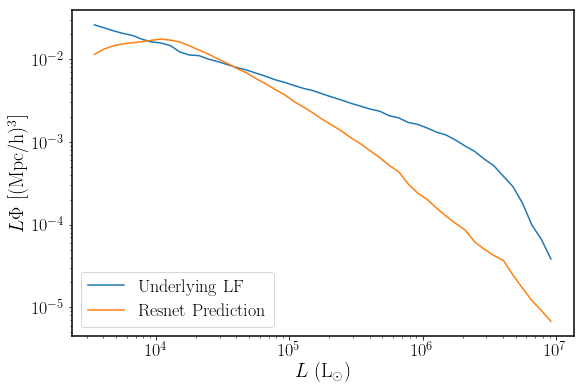

96 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13763_rotate_0_subfield_16__Li_-3.010e-03_1.360e+00_-1.941e+00_2.936e-01_2.941e-01 ----------------------------
Error and MSE for the given base_number:
[0.10854159295558929, 0.23954962193965912]


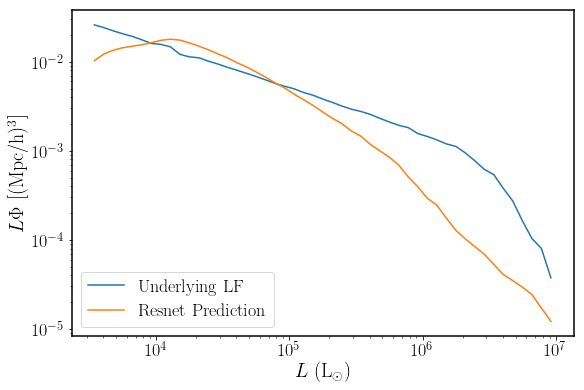

97 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13727_rotate_0_subfield_17__Li_-2.696e-02_1.343e+00_-2.140e+00_2.929e-01_3.021e-01 ----------------------------
Error and MSE for the given base_number:
[0.033142413944005966, 0.067774951457977295]


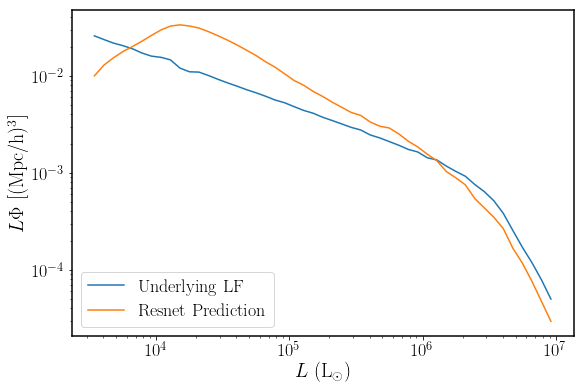

98 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13817_rotate_0_subfield_22__Li_-1.789e-02_1.385e+00_-1.933e+00_2.980e-01_3.116e-01 ----------------------------
Error and MSE for the given base_number:
[0.1014779657125473, 0.22103050351142883]


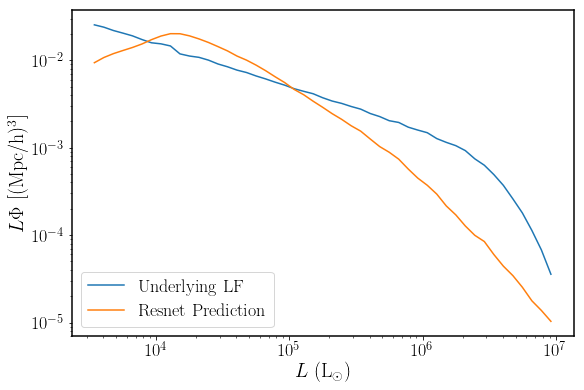

99 ../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13817_rotate_0_subfield_14__Li_3.142e-03_1.341e+00_-2.073e+00_3.174e-01_2.982e-01 ----------------------------
Error and MSE for the given base_number:
[0.051312144845724106, 0.10593682527542114]


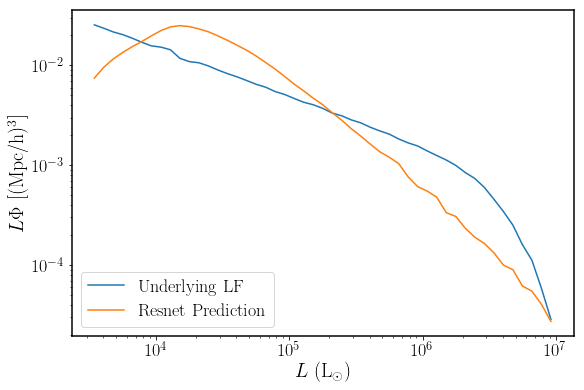

In [21]:
numb = 523

for numb in range(100):
    print(numb, random_small_Li_base[-numb], '----------------------------')
    cur_lum_Pad, cnn_lum_Pad, loss = lnn.test_model(noisy_foreground_random_resnet, basic_Padmanabhan_base, -numb, 'log', True, pre_pool=4, 
                                      log_input=True, pre_pool_z=10, lum_func_size=lum_func_size,
                                       make_map_noisy=(0,6.31), add_foregrounds=True,
                                       random_foreground_params=True, gaussian_smoothing=3,
                                                 pix_x=256, pix_y=256)
    
    fig, ax = plt.subplots(figsize=(9, 6))

    true_lum = 10**cur_lum_Pad
    cnn_guess = 10**cnn_lum_Pad[0]

    plt.plot(lumLogBinCents, true_lum/conv, label='Underlying LF')
    plt.plot(lumLogBinCents, cnn_guess/conv, label='Resnet Prediction')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$L$ (L$_{\odot}$)')
    plt.ylabel('$L \Phi$ [(Mpc/h)$^3$]')
    plt.legend(loc='lower left')
    
    plt.show(ax)


## IM Slices

In [7]:
%autoreload

In [8]:
data = np.load(base[750] + '_map.npz')
# data = np.load(random_small_Li_base[745] + '_map.npz')


basic_map = data['map_cube']
log_mod_basic_map = lnn.log_modulus(basic_map)

noisy_map = np.random.normal(0, 3.47, basic_map.shape)

model_params_obj = lnn.ModelParams()
model_params_obj.give_attributes(pre_pool=1, pre_pool_z=1)
model_params_obj.clean_parser_data()
model_params_obj.get_map_info(random_small_Li_base[745] + '_map.npz')
foreground_map = lnn.makeFGcube(int(model_params_obj.pix_x), int(model_params_obj.pix_y), 
                                model_params_obj.omega_pix, model_params_obj.nu, 
                                random_foreground_params=False)

geometric_noise_map = lnn.make_geometric_noise_map(basic_map.shape, 1.0/22, 25)

combined_map = basic_map + noisy_map + foreground_map

In [9]:
basic_pool_map = skimage.measure.block_reduce(basic_map, (4, 4, 1), np.sum)
noisy_pool_map = skimage.measure.block_reduce(noisy_map, (4, 4, 1), np.sum)
foreground_pool_map = skimage.measure.block_reduce(foreground_map, (4, 4, 1), np.sum)
geometric_pool_noise_map = skimage.measure.block_reduce(geometric_noise_map, (4, 4, 1), np.sum)
combined_pool_map = skimage.measure.block_reduce(combined_map, (4, 4, 1), np.sum)

In [10]:
basic_pool_map_smoothed = lnn.apply_gaussian_smoothing(basic_pool_map, 3)
noisy_pool_map_smoothed = lnn.apply_gaussian_smoothing(noisy_pool_map, 3)
foreground_pool_map_smoothed = lnn.apply_gaussian_smoothing(foreground_pool_map, 3)
geometric_pool_noise_map_smoothed = lnn.apply_gaussian_smoothing(geometric_pool_noise_map, 3)
combined_pool_map_smoothed = lnn.apply_gaussian_smoothing(combined_pool_map, 3)

In [22]:
data2 = np.load(random_small_Li_base[750] + '_map.npz')
basic_map2 = data2['map_cube']

noisy_map_temp = np.random.normal(0, 102, basic_map2.shape)

In [13]:
basic_pool_map2 = skimage.measure.block_reduce(basic_map2, (4, 4, 1), np.sum)
basic_pool_map_smoothed2 = lnn.apply_gaussian_smoothing(basic_pool_map2, 3)
basic_pool_map_smoothed3 = lnn.apply_gaussian_smoothing(basic_map2, 6)
basic_pool_map3 = skimage.measure.block_reduce(basic_pool_map_smoothed3, (4, 4, 1), np.sum)

In [23]:
noisy_map_temp_pooled = skimage.measure.block_reduce(noisy_map_temp, (4, 4, 1), np.sum)
noisy_map_temp_smoothed = lnn.apply_gaussian_smoothing(noisy_map_temp_pooled, 3)

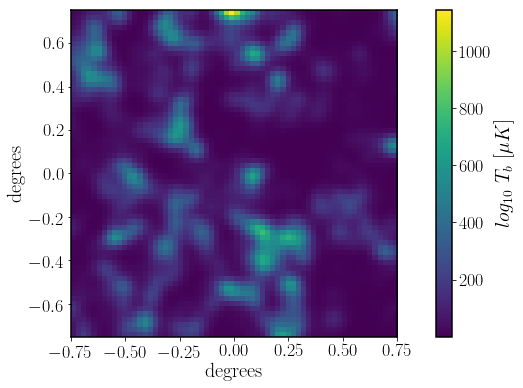

In [14]:
plt.figure(figsize=(14, 6))
im = plt.imshow(basic_pool_map_smoothed2[:,:,0],
                extent=[-1.5/2,1.5/2,-1.5/2,1.5/2])#,
                #vmin=-1,vmax=2)

plt.colorbar(im,label=r'$log_{10}\ T_b\ [\mu K]$')
plt.xlabel('degrees')
plt.ylabel('degrees')
# plt.title('simulated map at {0:.3f} GHz'.format(data['map_frequencies'][0]))

plt.show()

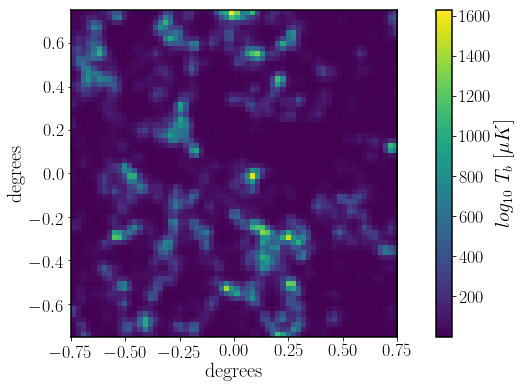

In [15]:
plt.figure(figsize=(14, 6))
im = plt.imshow(basic_pool_map3[:,:,0],
                extent=[-1.5/2,1.5/2,-1.5/2,1.5/2])#,
                #vmin=-1,vmax=2)

plt.colorbar(im,label=r'$log_{10}\ T_b\ [\mu K]$')
plt.xlabel('degrees')
plt.ylabel('degrees')
# plt.title('simulated map at {0:.3f} GHz'.format(data['map_frequencies'][0]))

plt.show()

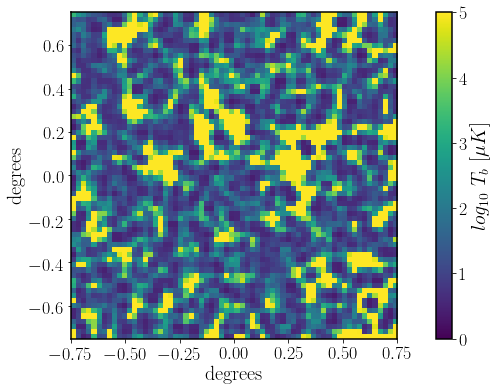

In [34]:
plt.figure(figsize=(14, 6))
im = plt.imshow(basic_pool_map_smoothed2[:,:,0]/basic_pool_map3[:,:,0],
                extent=[-1.5/2,1.5/2,-1.5/2,1.5/2],
                vmin=0,vmax=5)

plt.colorbar(im,label=r'$log_{10}\ T_b\ [\mu K]$')
plt.xlabel('degrees')
plt.ylabel('degrees')
# plt.title('simulated map at {0:.3f} GHz'.format(data['map_frequencies'][0]))

plt.show()

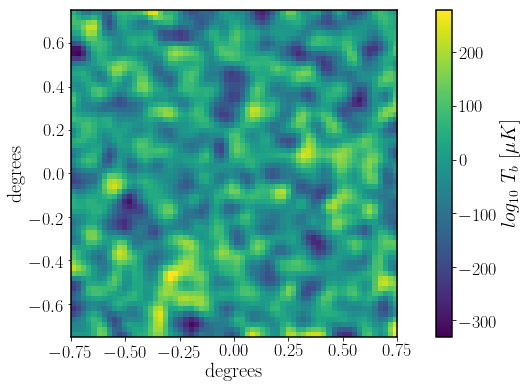

In [24]:
plt.figure(figsize=(14, 6))
im = plt.imshow(noisy_map_temp_smoothed[:,:,0],
                extent=[-1.5/2,1.5/2,-1.5/2,1.5/2])#,
                #vmin=-1,vmax=2)

plt.colorbar(im,label=r'$log_{10}\ T_b\ [\mu K]$')
plt.xlabel('degrees')
plt.ylabel('degrees')
# plt.title('simulated map at {0:.3f} GHz'.format(data['map_frequencies'][0]))

plt.show()

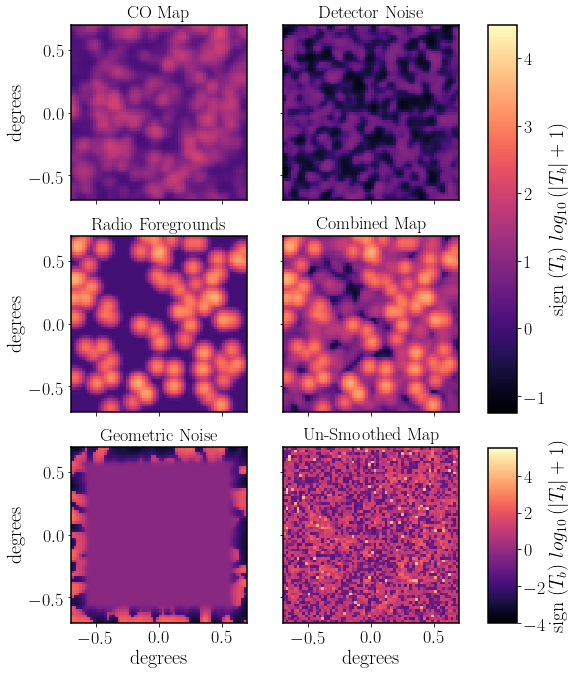

In [11]:
import matplotlib.colors as colors

fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(8, 11))

cmap = 'magma'

im = ax[0,0].imshow(lnn.log_modulus(basic_pool_map_smoothed[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-1.25,vmax=4.5, cmap=cmap)

im = ax[0,1].imshow(lnn.log_modulus(noisy_pool_map_smoothed[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-1.25,vmax=4.5, cmap=cmap)

im = ax[1,0].imshow(lnn.log_modulus(foreground_pool_map_smoothed[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-1.25,vmax=4.5, cmap=cmap)

im = ax[1,1].imshow(lnn.log_modulus(combined_pool_map_smoothed[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-1.25,vmax=4.5, cmap=cmap)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.39, 0.05, 0.49])
fig.colorbar(im, cax=cbar_ax, label=r'\rm{sign} $\left(T_b \right)$ $log_{10}\left( |T_b| + 1 \right)$')

im = ax[2,0].imshow(lnn.log_modulus(geometric_pool_noise_map_smoothed[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-4.0,vmax=6.2, cmap=cmap)

im = ax[2,1].imshow(lnn.log_modulus(combined_pool_map[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-4.0,vmax=5.5, cmap=cmap)

fig.subplots_adjust(right=0.8)
cbar_ax2 = fig.add_axes([0.85, 0.125, 0.05, 0.22])
fig.colorbar(im, cax=cbar_ax2, label=r'\rm{sign} $\left(T_b \right)$ $log_{10}\left( |T_b| + 1 \right)$')

# ax[0,0].text(0.0, 0.60,'CO Map', color='cyan', fontsize=22, horizontalalignment='center', verticalalignment='top')
# ax[0,1].text(0.0, 0.60,'Detector Noise', color='cyan', fontsize=22, horizontalalignment='center', verticalalignment='top')
# ax[1,0].text(0.0, 0.60,'Radio Foregrounds', color='cyan', fontsize=22, horizontalalignment='center', verticalalignment='top')
# ax[1,1].text(0.0, 0.60,'Combined Map', color='cyan', fontsize=22, horizontalalignment='center', verticalalignment='top')
# ax[2,0].text(0.0, 0.60,'Geometric Noise', color='cyan', fontsize=22, horizontalalignment='center', verticalalignment='top')
# ax[2,1].text(0.0, 0.60,'Down-sampled Map', color='cyan', fontsize=22, horizontalalignment='center', verticalalignment='top')

ax[0,0].set_title('CO Map', fontsize=18)
ax[0,1].set_title('Detector Noise', fontsize=18)
ax[1,0].set_title('Radio Foregrounds', fontsize=18)
ax[1,1].set_title('Combined Map', fontsize=18)
ax[2,0].set_title('Geometric Noise', fontsize=18)
ax[2,1].set_title('Un-Smoothed Map', fontsize=18)

ax[0,0].set_adjustable('box-forced')
ax[0,1].set_adjustable('box-forced')
ax[1,0].set_adjustable('box-forced')
ax[1,1].set_adjustable('box-forced')
ax[2,0].set_adjustable('box-forced')
ax[2,1].set_adjustable('box-forced')

ax[0,0].set_ylabel('degrees')
ax[1,0].set_ylabel('degrees')
ax[2,0].set_ylabel('degrees')

ax[2,0].set_xlabel('degrees')
ax[2,1].set_xlabel('degrees')

# plt.show()
plt.savefig('../figures/IM_slices.pdf', bbox_inches='tight')

# Not a figure, but needed for a table

## Figure out how accurate the scenarios are at different L

In [75]:
pred_dict = {}
pred_dict['No Noise Base Li'] = nfr_basic_resnet_basic_Li_pred
pred_dict['White Noise Base Li'] = nfr_noisy_resnet_basic_Li_pred
pred_dict['Random White Noise and Foregrounds Base Li'] = nfr_noisy_foreground_random_resnet_basic_Li_pred

pred_dict['No Noise Li'] = nfr_basic_resnet_pred
pred_dict['White Noise Li'] = nfr_noisy_resnet_pred
pred_dict['Random White Noise and Foregrounds Li'] = nfr_noisy_foreground_random_resnet_pred

pred_dict['Padmanabhan'] = basic_Padmanabhan_pred
pred_dict['Geometric Noise'] = geometric_noise_pred
pred_dict['Less Bright Sources'] = less_high_sources_pred

scenarios = ['No Noise Base Li', 'White Noise Base Li', 'Random White Noise and Foregrounds Base Li',
            'No Noise Li', 'White Noise Li', 'Random White Noise and Foregrounds Li',
            'Padmanabhan', 'Geometric Noise', 'Less Bright Sources',
            'Ihle et al.']

In [76]:
accuracies = {}
lumSpots = [6,20,34]

fiducial_pred = nfr_noisy_resnet_basic_Li_pred
conf_interval = np.array([fiducial_pred.transformed_res_conf_interval[:,0], fiducial_pred.transformed_res_conf_interval[:,1]])

fid_acc = []
fid_acc2 = []
for spot in lumSpots:
    fid_acc.append(conf_interval[1,spot])
    fid_acc2.append(conf_interval[0,spot])
fid_acc = fid_acc[0] #np.array(fid_acc)
fid_acc2 = fid_acc2[0] #np.array(fid_acc2)

for key, value in pred_dict.items():
    conf_interval = np.array([value.transformed_res_conf_interval[:,0], value.transformed_res_conf_interval[:,1]])
    
    acc = []
    acc2 = []
    for spot in lumSpots:
        acc.append(conf_interval[1,spot])
        acc2.append(conf_interval[0,spot])

    acc = np.array(acc)
    compare_acc = acc/fid_acc
    acc2 = np.array(acc2)
    compare_acc2 = acc2/fid_acc2
    accuracies[key] = np.array([acc, compare_acc, acc2, compare_acc2])
    
acc = []
acc2 = []
for spot in [4, 20, 36]:
    acc.append(2*upper_err[spot]/simulated_phi[spot])
    acc2.append(-2*lower_err[spot]/simulated_phi[spot])
    
acc = np.array(acc)
compare_acc = acc/fid_acc
acc2 = np.array(acc2)
compare_acc2 = acc2/fid_acc2
accuracies['Ihle et al.'] = np.array([acc, compare_acc, acc2, compare_acc2])

In [77]:
for scenario in scenarios:
    print(scenario, accuracies[scenario][0], accuracies[scenario][1])
    print("{0:1.2} & {1:1.2} & {2:1.2}".format((accuracies[scenario][1][0] + accuracies[scenario][3][0])/2, 
         (accuracies[scenario][1][1] + accuracies[scenario][3][1])/2, 
         (accuracies[scenario][1][2] + accuracies[scenario][3][2])/2))
    print()

No Noise Base Li [ 0.28452966  0.41885976  0.20564179] [ 0.6165639   0.90765164  0.44561718]
0.83 & 0.96 & 1.6

White Noise Base Li [ 0.46147635  0.77130917  0.79218171] [ 1.          1.6713948   1.71662473]
1.0 & 1.3 & 2.2

Random White Noise and Foregrounds Base Li [ 0.51114242  0.82058236  1.04707773] [ 1.1076243   1.77816775  2.26897378]
1.0 & 1.3 & 2.4

No Noise Li [ 0.95774314  1.17254587  5.26836263] [  2.07538946   2.540858    11.41632214]
1.5 & 1.7 & 7.0

White Noise Li [ 1.36323094  2.51903672  6.07137159] [  2.95406461   5.45864753  13.15640905]
2.0 & 3.2 & 7.9

Random White Noise and Foregrounds Li [ 1.2814402   2.55053294  7.58282293] [  2.77682747   5.52689852  16.4316611 ]
1.8 & 3.1 & 9.4

Padmanabhan [ 1.32918075  2.82448208  5.83532571] [  2.88027926   6.12053489  12.64490748]
1.9 & 3.5 & 7.6

Geometric Noise [  2.97150891   8.16036561  31.30724905] [  6.4391359   17.683172    67.84150319]
3.6 & 8.7 & 3.5e+01

Less Bright Sources [ 1.19744302  2.76721549  8.34032805] [

In [78]:
for scenario in scenarios:
    print(scenario, accuracies[scenario][0], accuracies[scenario][1])
    print("{0:1.2} / {3:1.3} & {1:1.2} / {4:1.3} & {2:1.2} / {5:1.3}".format(accuracies[scenario][3][0], 
         accuracies[scenario][3][1], accuracies[scenario][3][2], accuracies[scenario][1][0],
         accuracies[scenario][1][1], accuracies[scenario][1][2]))
    print()

No Noise Base Li [ 0.28452966  0.41885976  0.20564179] [ 0.6165639   0.90765164  0.44561718]
1.1 / 0.617 & 1.0 / 0.908 & 2.7 / 0.446

White Noise Base Li [ 0.46147635  0.77130917  0.79218171] [ 1.          1.6713948   1.71662473]
1.0 / 1.0 & 0.9 / 1.67 & 2.6 / 1.72

Random White Noise and Foregrounds Base Li [ 0.51114242  0.82058236  1.04707773] [ 1.1076243   1.77816775  2.26897378]
0.96 / 1.11 & 0.84 / 1.78 & 2.6 / 2.27

No Noise Li [ 0.95774314  1.17254587  5.26836263] [  2.07538946   2.540858    11.41632214]
0.95 / 2.08 & 0.96 / 2.54 & 2.6 / 11.4

White Noise Li [ 1.36323094  2.51903672  6.07137159] [  2.95406461   5.45864753  13.15640905]
0.98 / 2.95 & 1.0 / 5.46 & 2.6 / 13.2

Random White Noise and Foregrounds Li [ 1.2814402   2.55053294  7.58282293] [  2.77682747   5.52689852  16.4316611 ]
0.9 / 2.78 & 0.76 / 5.53 & 2.4 / 16.4

Padmanabhan [ 1.32918075  2.82448208  5.83532571] [  2.88027926   6.12053489  12.64490748]
0.97 / 2.88 & 0.79 / 6.12 & 2.5 / 12.6

Geometric Noise [  2.97